In [1]:
import sys

sys.path.insert(0, '../')

from modules.VT_dataset import *
from modules.train_prep import *
from modules.plot_results import *

In [2]:
class EEGMLP(nn.Module):
    """
    A multilayer perceptron (MLP) neural network model for EEG data classification.
    Args:
    - input_size: The number of input features (e.g., number of EEG channels * number of time points per sample).
    - num_classes: The number of output classes for the classification task.
    """
    def __init__(self, input_size, num_classes=4):
        super(EEGMLP, self).__init__()
        # Initialize the base class, nn.Module.
        
        # Define the architecture of the MLP:
        # First fully connected layer from input_size to 512 nodes.
        self.fc1 = nn.Linear(input_size, 512)  # First hidden layer
        
        # Second fully connected layer from 512 to 256 nodes.
        self.fc2 = nn.Linear(512, 256)         # Second hidden layer
        
        # Third fully connected layer from 256 to 128 nodes.
        self.fc3 = nn.Linear(256, 128)         # Third hidden layer
        
        # Output layer: fully connected layer from 128 nodes to num_classes nodes.
        self.fc4 = nn.Linear(128, num_classes) # Output layer

    def forward(self, x):
        """
        Defines the forward pass of the MLP.
        Args:
        - x: Input tensor containing a batch of input data.
        
        Returns:
        - x: The output of the network after passing through the layers.
        """
        # Flatten the input tensor to match the expected input dimensions of the first fully connected layer.
        # This is necessary if the input tensor has more than two dimensions (e.g., batch_size x channels x data_points).
        x = x.view(x.size(0), -1)
        
        # Apply a ReLU activation function to the output of the first fully connected layer.
        x = F.relu(self.fc1(x))  # Activation function for the first layer
        
        # Apply a ReLU activation function to the output of the second fully connected layer.
        x = F.relu(self.fc2(x))  # Activation function for the second layer
        
        # Apply a ReLU activation function to the output of the third fully connected layer.
        x = F.relu(self.fc3(x))  # Activation function for the third layer
        
        # Output layer: No activation function is applied here because it's common to apply softmax
        # or sigmoid separately during the loss computation phase, especially for classification tasks.
        x = self.fc4(x)          # Output of the network is the input to the final layer
        
        return x


In [3]:
# Check if CUDA is available and set the device accordingly
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_device)  # Use a specific CUDA device if available
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")  # Use Metal Performance Shaders (MPS) if on macOS with available support

# Define transformations for the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),  # Convert images/pil_images to tensor, and also normalizes (0, 1)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

# Setup datasets and their corresponding loaders
dsets = {
    'train': RawDataset(train_dir, train_behav_file, data_transforms['train']),
    'val': RawDataset(val_dir, val_behav_file, data_transforms['val'])
}
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}  # Get the size of each dataset

# Prepare data loaders, applying a weighted sampling strategy to handle class imbalance
dset_loaders = {}
for split in ['train', 'val']:
    targets = np.array([dsets[split].get_label(i) for i in range(len(dsets[split]))])
    class_counts = dsets[split].get_class_counts()
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=b_size, num_workers=0, sampler=sampler)
    print('done making loader:', split)

# Initialize the EEGMLP model, loss function, and optimizer
model_ft = EEGMLP(input_size=129*1250, num_classes=4)  # Initialize model with specified input size and number of classes
criterion = nn.CrossEntropyLoss()  # Loss function suitable for classification
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-5)  # Optimizer with learning rate and weight decay

# Set the device for the model and criterion based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model_ft.to(device)
criterion.to(device)
print(f"Training on {device}")

# Execute the training process
model_ft, accuracies, losses, preds, labels = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, dset_loaders, dset_sizes, num_epochs=n_epochs
)


  0%|                                                                                                                                                                                     | 0/192 [00:00<?, ?it/s]


  2%|██▋                                                                                                                                                                          | 3/192 [00:00<00:06, 28.85it/s]


  4%|██████▎                                                                                                                                                                      | 7/192 [00:00<00:06, 30.55it/s]


  6%|█████████▊                                                                                                                                                                  | 11/192 [00:00<00:06, 29.90it/s]


  8%|█████████████▍                                                                                                                                                              | 15/192 [00:00<00:05, 29.99it/s]


 10%|█████████████████                                                                                                                                                           | 19/192 [00:00<00:05, 30.47it/s]


 12%|████████████████████▌                                                                                                                                                       | 23/192 [00:00<00:05, 30.04it/s]


 14%|████████████████████████▏                                                                                                                                                   | 27/192 [00:00<00:05, 29.70it/s]


 16%|███████████████████████████▊                                                                                                                                                | 31/192 [00:01<00:05, 30.29it/s]


 18%|███████████████████████████████▎                                                                                                                                            | 35/192 [00:01<00:05, 30.11it/s]


 20%|██████████████████████████████████▉                                                                                                                                         | 39/192 [00:01<00:05, 29.93it/s]


 22%|██████████████████████████████████████▌                                                                                                                                     | 43/192 [00:01<00:04, 30.38it/s]


 24%|██████████████████████████████████████████                                                                                                                                  | 47/192 [00:01<00:04, 29.96it/s]


 26%|████████████████████████████████████████████▊                                                                                                                               | 50/192 [00:01<00:04, 29.77it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                            | 53/192 [00:01<00:04, 29.38it/s]


 30%|███████████████████████████████████████████████████                                                                                                                         | 57/192 [00:01<00:04, 29.42it/s]


 31%|█████████████████████████████████████████████████████▊                                                                                                                      | 60/192 [00:02<00:04, 29.25it/s]


 33%|████████████████████████████████████████████████████████▍                                                                                                                   | 63/192 [00:02<00:04, 29.00it/s]


 35%|████████████████████████████████████████████████████████████                                                                                                                | 67/192 [00:02<00:04, 29.39it/s]


 36%|██████████████████████████████████████████████████████████████▋                                                                                                             | 70/192 [00:02<00:04, 29.36it/s]


 38%|█████████████████████████████████████████████████████████████████▍                                                                                                          | 73/192 [00:02<00:04, 29.52it/s]


 40%|████████████████████████████████████████████████████████████████████                                                                                                        | 76/192 [00:02<00:03, 29.57it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                    | 80/192 [00:02<00:03, 30.05it/s]


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                 | 83/192 [00:02<00:03, 29.60it/s]


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                               | 86/192 [00:02<00:03, 29.59it/s]


 46%|███████████████████████████████████████████████████████████████████████████████▋                                                                                            | 89/192 [00:02<00:03, 29.35it/s]


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 93/192 [00:03<00:03, 29.80it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 96/192 [00:03<00:03, 29.55it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 99/192 [00:03<00:03, 29.36it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 103/192 [00:03<00:02, 29.97it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 106/192 [00:03<00:02, 29.44it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 110/192 [00:03<00:02, 29.78it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 113/192 [00:03<00:02, 29.38it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 117/192 [00:03<00:02, 29.67it/s]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 120/192 [00:04<00:02, 29.43it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 123/192 [00:04<00:02, 29.08it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 127/192 [00:04<00:02, 29.66it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 130/192 [00:04<00:02, 29.31it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 133/192 [00:04<00:02, 29.35it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 137/192 [00:04<00:01, 29.51it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 141/192 [00:04<00:01, 29.77it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 144/192 [00:04<00:01, 29.67it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/192 [00:04<00:01, 29.51it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 151/192 [00:05<00:01, 29.90it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 154/192 [00:05<00:01, 29.36it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 157/192 [00:05<00:01, 29.38it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 160/192 [00:05<00:01, 29.37it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 164/192 [00:05<00:00, 29.90it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 167/192 [00:05<00:00, 29.65it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 170/192 [00:05<00:00, 29.59it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 173/192 [00:05<00:00, 29.24it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 177/192 [00:05<00:00, 29.65it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 180/192 [00:06<00:00, 29.58it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 183/192 [00:06<00:00, 29.42it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 187/192 [00:06<00:00, 29.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 190/192 [00:06<00:00, 29.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:06<00:00, 29.64it/s]

Class counts:  {'HEHF': 2489, 'HELF': 238, 'LEHF': 1371, 'LELF': 878}



  0%|                                                                                                                                                                                      | 0/48 [00:00<?, ?it/s]


  8%|██████████████▌                                                                                                                                                               | 4/48 [00:00<00:01, 38.93it/s]


 19%|████████████████████████████████▋                                                                                                                                             | 9/48 [00:00<00:00, 41.01it/s]


 29%|██████████████████████████████████████████████████▍                                                                                                                          | 14/48 [00:00<00:01, 30.90it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                            | 18/48 [00:00<00:00, 32.33it/s]


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                             | 22/48 [00:00<00:00, 34.07it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 27/48 [00:00<00:00, 35.01it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 31/48 [00:00<00:00, 33.75it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 35/48 [00:01<00:00, 32.20it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 39/48 [00:01<00:00, 31.27it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 43/48 [00:01<00:00, 31.39it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 47/48 [00:01<00:00, 30.59it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.41it/s]

Class counts:  {'HEHF': 508, 'HELF': 101, 'LEHF': 535, 'LELF': 100}
done making loader: train
done making loader: val


Training on mps



  0%|                                                                                                                                                                                       | 0/5 [00:00<?, ?it/s]

----------
Epoch 0/4
----------
LR is set to 0.0001

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:01<08:23,  4.93it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:01<04:35,  8.98it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:01<03:23, 12.13it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:01<02:46, 14.83it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:01<02:22, 17.34it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:02<02:11, 18.70it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:02<01:59, 20.49it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:02<01:50, 22.07it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:02<01:45, 23.11it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:02<01:47, 22.71it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:03<01:43, 23.54it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:03<01:35, 25.50it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:03<01:35, 25.34it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:03<01:32, 26.21it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:03<01:30, 26.73it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:04<01:34, 25.51it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:04<01:37, 24.55it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:04<01:39, 24.15it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:04<01:36, 24.72it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:04<01:30, 26.50it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:05<01:33, 25.41it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:05<01:34, 25.18it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:05<01:32, 25.61it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:05<01:32, 25.63it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:05<01:26, 27.16it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:05<01:23, 28.26it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:06<01:23, 28.14it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:06<01:22, 28.42it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:06<01:20, 28.93it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:06<01:21, 28.68it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:06<01:21, 28.78it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:07<01:18, 29.52it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:07<01:22, 28.32it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:07<01:18, 29.65it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:07<01:18, 29.43it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:07<01:15, 30.39it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:07<01:23, 27.48it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:08<01:20, 28.49it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:08<01:18, 29.30it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:08<01:16, 29.91it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:08<01:18, 29.23it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:08<01:16, 29.72it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:08<01:19, 28.45it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:09<01:16, 29.61it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:09<01:17, 29.25it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:09<01:19, 28.56it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:09<01:18, 28.54it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:09<01:19, 28.41it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:09<01:17, 28.99it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:10<01:15, 29.46it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:10<01:14, 29.96it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:10<01:16, 29.22it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:10<01:14, 29.73it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:10<01:12, 30.53it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:10<01:12, 30.42it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:11<01:15, 29.25it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:11<01:16, 28.77it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:11<01:14, 29.55it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:11<01:15, 29.21it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:11<01:13, 29.68it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:11<01:12, 30.20it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:12<01:15, 28.67it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:12<01:16, 28.37it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:12<01:14, 28.97it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:12<01:12, 29.67it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:12<01:13, 29.31it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:12<01:12, 29.57it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:13<01:11, 29.98it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:13<01:10, 30.36it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:13<01:09, 30.67it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:13<01:11, 29.73it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:13<01:11, 29.64it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:13<01:13, 29.07it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:14<01:12, 29.40it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:14<01:09, 30.50it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:14<01:11, 29.36it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:14<01:09, 30.12it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:14<01:08, 30.75it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:14<01:07, 30.89it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:15<01:07, 31.04it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:15<01:07, 30.98it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:15<01:06, 31.09it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:15<01:06, 31.17it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:15<01:06, 31.25it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:15<01:05, 31.51it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:16<01:05, 31.53it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:16<01:08, 29.98it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:16<01:06, 30.79it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:16<01:06, 30.84it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:16<01:06, 30.64it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:16<01:05, 31.11it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:17<01:06, 30.54it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:17<01:05, 30.80it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:17<01:04, 31.20it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:17<01:04, 31.21it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:17<01:03, 31.72it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:17<01:03, 31.70it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:18<01:02, 31.88it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:18<01:02, 31.68it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:18<01:02, 31.92it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:18<01:02, 31.87it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:18<01:02, 31.57it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:18<01:03, 31.14it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:18<01:02, 31.31it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:19<01:03, 30.90it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:19<01:02, 31.20it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:19<01:02, 31.27it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:19<01:02, 31.07it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:19<01:02, 31.28it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:19<01:01, 31.64it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:20<01:01, 31.34it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:20<01:01, 31.60it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:20<01:00, 31.67it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:20<01:03, 30.17it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:20<01:03, 30.13it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:20<01:02, 30.55it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:21<01:01, 31.15it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:21<01:00, 31.21it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:21<01:00, 31.25it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:21<01:00, 31.23it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:21<01:01, 30.83it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:21<01:00, 31.12it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:22<00:59, 31.37it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:22<00:59, 31.16it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:22<01:00, 31.00it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:22<00:59, 31.02it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:22<00:59, 30.95it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:22<00:59, 30.87it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:22<00:59, 30.73it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:23<00:58, 31.15it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:23<01:00, 30.14it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:23<00:59, 30.49it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:23<00:59, 30.57it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:23<00:58, 30.87it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:23<00:58, 31.13it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:24<00:58, 30.75it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:24<00:58, 30.72it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:24<00:57, 31.06it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:24<00:56, 31.53it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:24<00:56, 31.48it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:24<00:55, 31.86it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:25<00:55, 31.93it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:25<00:55, 31.91it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:25<00:54, 32.18it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:25<00:56, 31.36it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:25<00:56, 31.04it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:25<00:56, 31.11it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:26<00:56, 30.95it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:26<00:56, 31.11it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:26<00:56, 30.92it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:26<00:57, 30.10it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:26<00:57, 30.16it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:26<00:56, 30.50it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:27<00:56, 30.50it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:27<00:54, 31.29it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:27<00:54, 31.25it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:27<00:54, 31.26it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:27<00:55, 30.85it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:27<00:53, 31.44it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:27<00:53, 31.51it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:28<00:52, 31.84it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:28<00:55, 30.46it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:28<00:53, 31.02it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:28<00:54, 30.80it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:28<00:54, 30.76it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:28<00:54, 30.54it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:29<00:54, 30.48it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:29<00:52, 31.15it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:29<00:52, 31.44it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:29<00:51, 31.54it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:29<00:51, 31.81it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:29<00:51, 31.51it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:30<00:50, 32.01it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:30<00:50, 31.74it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:30<00:50, 31.71it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:30<00:50, 31.69it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:30<00:50, 31.70it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:30<00:50, 31.36it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:31<00:51, 30.92it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:31<00:53, 29.92it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:31<00:52, 30.30it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:31<00:51, 30.81it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:31<00:50, 31.13it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:31<00:49, 31.91it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:31<00:49, 31.64it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:32<00:49, 31.31it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:32<00:49, 31.68it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:32<00:48, 31.80it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:32<00:48, 32.03it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:32<00:49, 31.15it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:32<00:49, 30.73it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:33<00:49, 30.61it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:33<00:48, 31.15it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:33<00:48, 31.21it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:33<00:48, 31.18it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:33<00:48, 30.99it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:33<00:48, 30.96it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:34<00:47, 31.47it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:34<00:46, 32.00it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:34<00:46, 31.92it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:34<00:46, 31.81it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:34<00:46, 31.65it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:34<00:46, 31.52it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:35<00:47, 31.19it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:35<00:46, 31.41it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:35<00:46, 31.60it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:35<00:46, 31.30it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:35<00:46, 31.47it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:35<00:45, 31.85it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:35<00:46, 31.18it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:36<00:45, 31.24it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:36<00:45, 31.14it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:36<00:45, 31.37it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:36<00:45, 31.38it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:36<00:44, 31.57it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:36<00:44, 31.45it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:37<00:44, 31.61it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:37<00:43, 31.83it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:37<00:43, 31.68it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:37<00:43, 31.71it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:37<00:44, 31.37it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:37<00:43, 31.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:38<00:43, 31.68it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:38<00:43, 31.16it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:38<00:43, 31.08it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:38<00:43, 31.47it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:38<00:42, 31.68it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:38<00:41, 32.22it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:38<00:41, 32.48it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:39<00:41, 32.36it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:39<00:41, 32.48it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:39<00:41, 32.23it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:39<00:41, 32.25it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:39<00:41, 32.04it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:39<00:40, 32.19it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:40<00:40, 32.01it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:40<00:41, 31.70it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:40<00:40, 31.74it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:40<00:40, 31.99it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:40<00:40, 31.73it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:40<00:40, 31.70it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:41<00:40, 31.79it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:41<00:39, 31.86it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:41<00:40, 31.53it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:41<00:39, 32.00it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:41<00:38, 32.45it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:41<00:38, 32.16it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:41<00:39, 31.94it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:42<00:39, 31.69it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:42<00:39, 31.57it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:42<00:39, 31.38it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:42<00:39, 31.09it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:42<00:39, 30.89it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:42<00:39, 31.18it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:43<00:37, 32.21it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:43<00:37, 32.19it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:43<00:37, 31.96it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:43<00:37, 31.78it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:43<00:37, 31.79it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:43<00:37, 31.63it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:44<00:37, 31.46it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:44<00:37, 31.78it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:44<00:36, 32.13it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:44<00:35, 32.63it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:44<00:36, 31.85it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:44<00:36, 31.69it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:44<00:36, 31.45it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:45<00:35, 31.89it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:45<00:36, 31.65it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:45<00:36, 31.57it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:45<00:35, 31.71it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:45<00:36, 31.33it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:45<00:35, 31.49it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:46<00:35, 31.66it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:46<00:35, 31.25it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:46<00:34, 32.06it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:46<00:34, 31.77it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:46<00:34, 32.09it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:46<00:34, 31.80it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:46<00:34, 31.73it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:47<00:34, 31.56it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:47<00:34, 31.58it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:47<00:34, 31.41it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:47<00:33, 31.64it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:47<00:33, 32.02it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:47<00:33, 31.95it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:48<00:32, 31.99it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:48<00:32, 31.89it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:48<00:32, 32.07it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:48<00:32, 31.52it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:48<00:32, 31.31it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:48<00:33, 31.05it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:49<00:32, 31.12it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:49<00:32, 31.08it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:49<00:32, 31.20it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:49<00:32, 30.94it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:49<00:32, 31.23it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:49<00:31, 31.36it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:50<00:31, 31.37it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:50<00:31, 31.41it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:50<00:31, 31.26it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:50<00:31, 31.35it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:50<00:31, 31.31it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:50<00:30, 31.27it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:50<00:30, 31.36it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:51<00:30, 31.53it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:51<00:30, 31.46it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:51<00:30, 31.52it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:51<00:29, 31.78it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:51<00:29, 31.64it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:51<00:29, 31.50it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:52<00:29, 31.16it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:52<00:29, 31.14it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:52<00:29, 31.32it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:52<00:29, 31.21it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:52<00:29, 31.14it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:52<00:28, 31.67it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:53<00:28, 31.54it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:53<00:27, 31.96it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [00:53<00:27, 32.07it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [00:53<00:27, 31.77it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [00:53<00:28, 31.33it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [00:53<00:28, 31.03it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [00:53<00:27, 31.34it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [00:54<00:27, 31.35it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [00:54<00:27, 31.46it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [00:54<00:26, 31.62it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [00:54<00:26, 31.93it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [00:54<00:26, 31.77it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [00:54<00:26, 31.74it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [00:55<00:26, 31.23it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [00:55<00:26, 31.17it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [00:55<00:26, 31.26it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [00:55<00:26, 31.19it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [00:55<00:26, 30.91it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [00:55<00:25, 31.24it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [00:56<00:25, 31.57it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [00:56<00:25, 31.28it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [00:56<00:25, 31.27it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [00:56<00:25, 31.01it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [00:56<00:25, 31.03it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [00:56<00:25, 31.01it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [00:57<00:24, 31.15it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [00:57<00:24, 31.08it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [00:57<00:24, 30.99it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [00:57<00:24, 31.36it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [00:57<00:23, 31.67it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [00:57<00:23, 31.63it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [00:57<00:23, 31.54it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [00:58<00:23, 31.48it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [00:58<00:23, 31.35it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [00:58<00:23, 30.92it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [00:58<00:22, 31.57it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [00:58<00:22, 31.39it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [00:58<00:22, 31.06it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [00:59<00:22, 31.02it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [00:59<00:22, 31.17it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [00:59<00:22, 30.76it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [00:59<00:22, 30.76it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [00:59<00:22, 30.68it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [00:59<00:21, 31.15it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [01:00<00:21, 31.23it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [01:00<00:21, 31.66it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [01:00<00:21, 31.67it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [01:00<00:21, 31.56it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [01:00<00:20, 31.76it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [01:00<00:20, 31.63it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [01:01<00:20, 31.56it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [01:01<00:20, 31.45it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [01:01<00:20, 31.47it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [01:01<00:20, 31.30it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [01:01<00:19, 31.45it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [01:01<00:20, 30.92it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [01:01<00:19, 31.19it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [01:02<00:19, 31.44it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [01:02<00:19, 31.40it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:02<00:19, 31.43it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:02<00:19, 31.36it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:02<00:18, 31.35it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:02<00:18, 31.45it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:03<00:18, 31.35it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:03<00:18, 31.27it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:03<00:18, 31.28it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:03<00:21, 26.47it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:03<00:20, 27.79it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:03<00:19, 29.10it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:04<00:18, 30.00it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:04<00:17, 30.72it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:04<00:17, 30.93it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:04<00:17, 31.08it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:04<00:17, 31.18it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:04<00:16, 31.19it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:05<00:16, 31.09it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:05<00:16, 30.84it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:05<00:16, 30.90it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:05<00:16, 31.23it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:05<00:16, 31.06it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:05<00:15, 31.36it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:06<00:15, 31.21it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:06<00:15, 31.26it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:06<00:15, 31.18it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:06<00:15, 31.13it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:06<00:15, 31.30it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:06<00:14, 31.44it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:07<00:14, 31.16it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:07<00:14, 30.93it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:07<00:14, 31.02it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:07<00:14, 31.35it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:07<00:14, 31.11it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:07<00:14, 31.04it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:07<00:13, 31.10it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:08<00:13, 31.55it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:08<00:13, 31.67it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:08<00:13, 31.91it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:08<00:12, 31.87it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:08<00:12, 31.55it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:08<00:12, 31.42it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:09<00:12, 31.49it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:09<00:12, 32.06it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:09<00:12, 31.84it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:09<00:12, 31.68it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:09<00:12, 31.30it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:09<00:11, 31.52it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:10<00:11, 31.94it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:10<00:11, 31.83it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:10<00:11, 31.65it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:10<00:11, 31.84it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:10<00:10, 32.16it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:10<00:10, 32.42it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:10<00:10, 31.69it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:11<00:10, 31.87it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:11<00:10, 32.48it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:11<00:10, 32.23it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:11<00:09, 32.26it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:11<00:09, 32.42it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:11<00:09, 32.08it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:12<00:09, 31.83it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:12<00:09, 31.65it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:12<00:09, 31.67it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:12<00:09, 31.40it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:12<00:08, 31.81it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:12<00:08, 32.26it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:12<00:08, 32.20it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:13<00:08, 31.78it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:13<00:08, 31.99it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:13<00:07, 32.41it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:13<00:07, 32.21it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:13<00:07, 32.29it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:13<00:07, 31.51it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:14<00:07, 31.85it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:14<00:07, 31.79it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:14<00:07, 31.57it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:14<00:07, 31.23it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:14<00:07, 30.85it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:14<00:06, 30.98it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:15<00:06, 31.46it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:15<00:06, 32.04it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:15<00:06, 31.69it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:15<00:06, 31.51it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:15<00:05, 31.36it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:15<00:05, 31.66it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:15<00:05, 31.69it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:16<00:05, 31.89it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:16<00:05, 31.64it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:16<00:05, 32.00it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:16<00:05, 31.48it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:16<00:04, 31.09it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:16<00:04, 31.74it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:17<00:04, 31.62it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:17<00:04, 31.63it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:17<00:04, 31.36it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:17<00:04, 31.61it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:17<00:03, 31.26it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:17<00:03, 31.34it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:18<00:03, 31.64it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:18<00:03, 31.98it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:18<00:03, 32.16it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:18<00:03, 32.06it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:18<00:02, 32.13it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:18<00:02, 32.41it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:18<00:02, 31.70it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:19<00:02, 31.50it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:19<00:02, 31.43it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:19<00:02, 31.04it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:19<00:02, 31.03it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:19<00:01, 31.14it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:19<00:01, 31.10it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:20<00:01, 31.19it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:20<00:01, 31.19it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:20<00:01, 31.40it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:20<00:01, 31.14it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:20<00:00, 30.99it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:20<00:00, 31.02it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:21<00:00, 31.18it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:21<00:00, 31.51it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:21<00:00, 31.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:21<00:00, 31.42it/s]


2490it [01:22, 11.64it/s]                                                                                                                                                                                         


2490it [01:22, 30.14it/s]

train Loss: 1.3753 Acc: 0.2870

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:13, 46.16it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:13, 46.98it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:13, 46.15it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:13, 46.23it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:13, 44.86it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:00<00:12, 45.80it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:00<00:12, 45.67it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:00<00:12, 46.08it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:00<00:12, 45.95it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:12, 45.74it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:12, 44.58it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:01<00:12, 44.33it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:01<00:12, 44.96it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:01<00:12, 44.86it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:01<00:12, 44.48it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:01<00:12, 44.57it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:01<00:12, 44.28it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:01<00:11, 45.07it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:02<00:11, 44.67it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:02<00:11, 44.97it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:02<00:11, 45.75it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:02<00:11, 44.92it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:02<00:11, 44.51it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:02<00:11, 44.24it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:02<00:11, 44.27it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:02<00:11, 44.05it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:03<00:11, 43.71it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:03<00:11, 43.58it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:03<00:10, 44.79it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:03<00:10, 44.88it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:03<00:10, 44.62it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:03<00:10, 44.37it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:03<00:10, 44.76it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:03<00:10, 45.00it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:03<00:09, 46.33it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:03<00:09, 45.89it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:04<00:09, 46.68it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:04<00:09, 46.01it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:04<00:09, 45.66it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:04<00:09, 45.48it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:04<00:09, 45.93it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:04<00:08, 46.39it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:04<00:08, 45.83it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:04<00:08, 45.24it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:04<00:08, 44.92it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:05<00:08, 45.51it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:05<00:08, 45.34it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:05<00:08, 44.14it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:05<00:08, 43.35it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:05<00:08, 43.42it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:05<00:08, 43.29it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:05<00:08, 43.74it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:05<00:08, 44.18it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:06<00:07, 44.20it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:06<00:07, 45.04it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:06<00:07, 44.99it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:06<00:07, 44.78it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:06<00:07, 44.86it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:06<00:07, 46.03it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:06<00:07, 45.31it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:06<00:06, 45.60it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:06<00:06, 45.00it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:07<00:06, 44.24it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:07<00:06, 44.47it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:07<00:06, 43.99it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:07<00:06, 44.72it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:07<00:06, 43.94it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:07<00:06, 44.10it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:07<00:06, 44.63it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:07<00:06, 44.74it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:07<00:05, 44.74it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:08<00:05, 44.48it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:08<00:05, 44.55it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:08<00:05, 44.11it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:08<00:05, 44.86it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:08<00:05, 44.51it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:08<00:05, 44.90it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:08<00:05, 45.65it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:08<00:04, 45.54it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:08<00:04, 44.52it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:09<00:04, 44.48it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:09<00:04, 43.99it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:09<00:04, 43.95it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:09<00:04, 43.83it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:09<00:04, 45.38it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:09<00:04, 45.70it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:09<00:03, 46.13it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:09<00:03, 46.16it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:10<00:03, 45.98it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:10<00:03, 46.34it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:10<00:03, 46.86it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:10<00:03, 46.39it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:10<00:03, 46.25it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:10<00:03, 45.82it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:10<00:03, 45.66it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:10<00:02, 46.04it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:11<00:02, 46.88it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:11<00:02, 46.20it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:11<00:02, 45.25it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:11<00:02, 44.99it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:11<00:02, 44.93it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:11<00:02, 43.80it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:11<00:02, 44.11it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:11<00:01, 43.71it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:12<00:01, 43.79it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:12<00:01, 44.39it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:12<00:01, 44.49it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:12<00:01, 45.33it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:12<00:01, 45.29it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:12<00:01, 44.81it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:12<00:01, 44.42it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:12<00:01, 45.30it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:12<00:00, 45.34it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:12<00:00, 44.88it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:13<00:00, 45.28it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:13<00:00, 45.52it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:13<00:00, 45.04it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:13<00:00, 44.85it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:13<00:00, 44.85it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:13<00:00, 45.25it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:13<00:00, 44.08it/s]


625it [00:14, 18.13it/s]                                                                                                                                                                                          


625it [00:14, 43.29it/s]


 20%|███████████████████████████████████                                                                                                                                            | 1/5 [01:37<06:28, 97.07s/it]

val Loss: 1.3965 Acc: 0.3167
New best accuracy = 0.3167
----------
Epoch 1/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:23, 29.60it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:21, 30.59it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:20, 30.87it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:19, 30.93it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:00<01:19, 31.13it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:00<01:19, 31.04it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:18, 31.24it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:17, 31.60it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:18, 31.22it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:01<01:17, 31.56it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:01<01:16, 31.64it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:01<01:16, 31.92it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:15, 32.02it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:02<01:15, 31.97it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:02<01:16, 31.55it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:02<01:17, 31.09it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:02<01:16, 31.26it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:02<01:15, 31.76it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:16, 31.10it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:03<01:16, 31.23it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:03<01:17, 30.89it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:03<01:17, 30.88it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:03<01:15, 31.33it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:03<01:14, 31.85it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:03<01:13, 31.95it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:04<01:14, 31.57it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:04<01:14, 31.73it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:04<01:14, 31.57it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:04<01:15, 31.15it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:04<01:14, 31.52it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:04<01:14, 31.43it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:05<01:13, 31.49it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:05<01:14, 31.34it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:05<01:14, 31.02it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:05<01:13, 31.40it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:05<01:14, 30.96it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:05<01:13, 31.51it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:06<01:13, 31.18it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:06<01:13, 31.14it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:06<01:13, 31.15it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:06<01:13, 31.23it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:06<01:12, 31.62it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:06<01:12, 31.57it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:07<01:11, 31.53it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:07<01:11, 31.81it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:07<01:11, 31.59it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:07<01:11, 31.61it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:07<01:11, 31.54it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:07<01:09, 32.13it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:07<01:08, 32.47it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:08<01:09, 32.21it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:08<01:10, 31.79it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:08<01:10, 31.72it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:08<01:09, 31.78it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:08<01:09, 31.69it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:08<01:09, 31.56it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:09<01:09, 31.50it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:09<01:09, 31.58it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:09<01:08, 32.23it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:09<01:08, 31.98it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:09<01:08, 31.77it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:09<01:09, 31.45it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:09<01:08, 31.71it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:10<01:07, 31.91it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:10<01:08, 31.62it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:10<01:07, 31.92it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:10<01:08, 31.48it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:10<01:07, 31.61it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:10<01:08, 31.11it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:11<01:08, 31.32it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:11<01:06, 32.07it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:11<01:06, 31.96it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:11<01:07, 31.61it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:11<01:07, 31.54it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:11<01:07, 31.40it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:12<01:06, 31.77it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:12<01:04, 32.64it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:12<01:04, 32.35it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:12<01:04, 32.58it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:12<01:03, 32.74it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:12<01:03, 32.61it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:12<01:04, 32.39it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:13<01:03, 32.45it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:13<01:03, 32.65it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:13<01:03, 32.46it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:13<01:02, 32.89it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:13<01:03, 32.43it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:13<01:03, 32.31it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:14<01:03, 32.39it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:14<01:03, 32.03it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:14<01:03, 31.79it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:14<01:04, 31.59it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:14<01:04, 31.21it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:14<01:04, 31.09it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:15<01:04, 31.09it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:15<01:05, 30.78it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:15<01:04, 31.02it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:15<01:04, 31.13it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:15<01:04, 31.14it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:15<01:03, 31.11it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:15<01:02, 31.66it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:16<01:02, 31.54it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:16<01:02, 31.38it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:16<01:02, 31.34it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:16<01:00, 32.23it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:16<01:01, 31.63it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:16<01:01, 31.86it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:17<01:01, 31.63it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:17<01:02, 31.29it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:17<01:02, 31.25it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:17<01:02, 31.07it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:17<01:01, 31.31it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:17<01:00, 31.74it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:18<01:00, 31.92it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:18<01:00, 31.76it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:18<01:01, 31.25it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:18<01:00, 31.22it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:18<01:01, 30.94it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:18<01:00, 31.20it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:18<01:01, 30.92it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:19<01:00, 31.24it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:19<00:58, 32.01it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:19<00:58, 32.02it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:19<00:59, 31.52it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:19<00:58, 31.70it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:19<00:59, 31.32it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:20<00:58, 31.41it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:20<00:58, 31.64it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:20<00:57, 31.91it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:20<00:58, 31.28it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:20<00:58, 31.30it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:20<00:58, 31.26it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:21<00:58, 31.41it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:21<00:58, 31.28it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:21<00:57, 31.70it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:21<00:57, 31.31it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:21<00:57, 31.56it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:21<00:56, 31.88it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:22<00:57, 31.43it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:22<00:56, 31.71it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:22<00:55, 31.98it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:22<00:55, 31.76it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:22<00:55, 31.83it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:22<00:55, 31.92it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:22<00:54, 32.10it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:23<00:55, 31.81it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:23<00:54, 32.15it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:23<00:54, 32.28it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:23<00:54, 31.88it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:23<00:54, 31.86it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:23<00:54, 32.08it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:24<00:53, 32.27it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:24<00:53, 32.37it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:24<00:54, 31.70it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:24<00:53, 32.14it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:24<00:52, 32.46it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:24<00:52, 32.32it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:24<00:53, 31.96it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:25<00:52, 32.14it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:25<00:52, 31.86it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:25<00:52, 31.78it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:25<00:53, 31.45it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:25<00:52, 31.73it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:25<00:53, 30.95it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:26<00:54, 30.73it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:26<00:53, 31.15it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:26<00:51, 32.08it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:26<00:52, 31.50it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:26<00:51, 31.65it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:26<00:51, 31.60it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:27<00:58, 27.98it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:27<00:55, 29.18it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:27<00:54, 29.82it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:27<00:53, 30.16it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:27<00:52, 30.57it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:27<00:52, 30.56it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:28<00:52, 30.62it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:28<00:51, 30.78it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:28<00:51, 30.86it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:28<00:50, 31.38it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:28<00:50, 31.50it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:28<00:49, 31.71it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:29<00:50, 31.26it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:29<00:49, 31.56it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:29<00:48, 31.90it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:29<00:49, 31.65it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:29<00:48, 31.75it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:29<00:49, 31.47it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:29<00:49, 31.09it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:30<00:49, 30.81it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:30<00:49, 30.76it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:30<00:49, 30.97it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:30<00:49, 31.01it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:30<00:51, 29.34it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:30<00:50, 29.98it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:31<00:50, 30.09it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:31<00:48, 30.89it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:31<00:48, 31.19it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:31<00:47, 31.13it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:31<00:47, 31.14it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:31<00:47, 31.28it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:32<00:47, 31.13it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:32<00:47, 31.18it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:32<00:46, 31.24it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:32<00:47, 30.94it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:32<00:46, 31.36it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:32<00:46, 31.01it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:33<00:46, 31.01it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:33<00:46, 31.06it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:33<00:46, 30.84it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:33<00:46, 30.88it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:33<00:45, 31.08it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:33<00:45, 31.14it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:34<00:45, 31.26it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:34<00:45, 31.15it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:34<00:45, 30.90it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:34<00:45, 30.84it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:34<00:44, 31.08it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:34<00:44, 31.10it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:34<00:45, 30.82it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:35<00:44, 31.06it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:35<00:44, 31.01it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:35<00:44, 31.03it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:35<00:45, 29.97it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:35<00:45, 30.09it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:35<00:44, 30.28it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:36<00:44, 30.32it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:36<00:44, 30.63it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:36<00:44, 30.42it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:36<00:43, 30.68it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:36<00:43, 30.79it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:36<00:43, 30.84it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:37<00:43, 30.71it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:37<00:42, 30.83it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:37<00:42, 30.87it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:37<00:42, 30.76it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:37<00:41, 31.17it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:37<00:41, 30.96it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:38<00:42, 30.61it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:38<00:42, 30.45it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:38<00:41, 31.08it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:38<00:41, 31.05it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:38<00:41, 30.81it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:38<00:41, 30.92it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:39<00:40, 31.07it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:39<00:40, 31.18it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:39<00:40, 31.21it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:39<00:40, 30.78it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:39<00:39, 31.23it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:39<00:39, 31.22it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:40<00:39, 31.04it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:40<00:39, 30.95it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:40<00:39, 31.13it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:40<00:39, 30.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:40<00:39, 30.69it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:40<00:38, 31.21it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:40<00:38, 31.08it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:41<00:38, 31.17it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:41<00:38, 31.26it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:41<00:37, 31.27it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:41<00:38, 30.81it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:41<00:38, 30.54it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:41<00:37, 31.12it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:42<00:36, 31.61it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:42<00:36, 31.54it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:42<00:37, 31.17it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:42<00:36, 31.51it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:42<00:36, 31.47it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:42<00:35, 31.81it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:43<00:35, 31.61it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:43<00:35, 31.56it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:43<00:35, 31.57it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:43<00:35, 31.38it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:43<00:35, 31.49it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:43<00:35, 31.74it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:43<00:35, 31.53it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:44<00:35, 31.51it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:44<00:34, 31.45it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:44<00:34, 31.34it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:44<00:34, 31.48it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:44<00:35, 30.74it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:44<00:35, 30.63it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:45<00:34, 31.26it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:45<00:33, 31.42it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:45<00:34, 30.81it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:45<00:34, 30.94it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:45<00:33, 31.10it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:45<00:34, 30.79it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:46<00:33, 31.25it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:46<00:33, 31.43it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:46<00:32, 31.38it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:46<00:33, 30.99it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:46<00:32, 31.25it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:46<00:33, 30.84it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:47<00:32, 31.06it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:47<00:32, 31.34it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:47<00:31, 31.66it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:47<00:31, 31.42it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:47<00:31, 31.57it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:47<00:31, 31.67it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:47<00:31, 31.67it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:48<00:31, 31.47it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:48<00:30, 31.88it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:48<00:30, 31.67it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:48<00:30, 31.65it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:48<00:29, 32.28it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:48<00:29, 31.95it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:49<00:30, 31.39it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:49<00:30, 31.02it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:49<00:30, 30.76it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:49<00:30, 30.41it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:49<00:30, 30.65it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:49<00:29, 31.16it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:50<00:29, 31.23it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:50<00:29, 31.28it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:50<00:29, 31.01it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:50<00:28, 31.35it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:50<00:28, 31.47it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:50<00:28, 31.42it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [00:51<00:28, 31.28it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [00:51<00:27, 31.66it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [00:51<00:27, 31.58it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [00:51<00:27, 31.24it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [00:51<00:27, 31.55it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [00:51<00:27, 30.98it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [00:51<00:27, 31.06it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [00:52<00:27, 31.07it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [00:52<00:27, 30.78it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [00:52<00:26, 31.67it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [00:52<00:26, 31.25it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [00:52<00:26, 31.36it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [00:52<00:26, 31.80it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [00:53<00:25, 31.69it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [00:53<00:26, 31.45it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [00:53<00:25, 31.72it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [00:53<00:25, 31.22it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [00:53<00:25, 31.75it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [00:53<00:25, 31.57it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [00:54<00:25, 31.43it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [00:54<00:25, 31.41it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [00:54<00:25, 31.17it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [00:54<00:24, 31.53it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [00:54<00:24, 31.71it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [00:54<00:24, 31.50it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [00:55<00:24, 31.49it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [00:55<00:23, 31.59it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [00:55<00:23, 31.45it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [00:55<00:23, 31.73it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [00:55<00:23, 32.03it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [00:55<00:22, 32.22it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [00:55<00:23, 31.68it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [00:56<00:22, 31.96it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [00:56<00:22, 32.57it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [00:56<00:22, 32.19it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [00:56<00:22, 31.89it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [00:56<00:22, 31.63it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [00:56<00:22, 31.40it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [00:57<00:22, 31.52it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [00:57<00:22, 31.41it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [00:57<00:21, 31.83it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [00:57<00:21, 31.94it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [00:57<00:21, 31.52it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [00:57<00:21, 31.36it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [00:58<00:21, 31.19it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [00:58<00:21, 31.46it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [00:58<00:21, 31.17it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [00:58<00:21, 31.02it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [00:58<00:20, 31.19it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [00:58<00:20, 31.15it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [00:58<00:20, 31.27it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [00:59<00:20, 31.15it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [00:59<00:20, 31.26it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [00:59<00:19, 32.03it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [00:59<00:19, 31.91it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [00:59<00:19, 31.69it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [00:59<00:19, 31.44it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [01:00<00:19, 31.18it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:00<00:18, 31.90it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:00<00:18, 31.90it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:00<00:18, 31.78it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:00<00:18, 31.35it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:00<00:18, 31.51it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:01<00:18, 30.92it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:01<00:18, 31.41it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:01<00:17, 31.40it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:01<00:17, 31.24it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:01<00:17, 31.40it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:01<00:17, 31.02it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:01<00:17, 30.98it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:02<00:17, 31.12it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:02<00:17, 31.20it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:02<00:16, 31.55it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:02<00:16, 31.15it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:02<00:16, 31.41it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:02<00:16, 31.17it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:03<00:16, 31.17it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:03<00:16, 31.28it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:03<00:15, 31.19it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:03<00:15, 30.99it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:03<00:15, 30.91it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:03<00:15, 31.45it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:04<00:15, 31.79it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:04<00:14, 31.68it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:04<00:14, 31.57it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:04<00:14, 31.57it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:04<00:14, 31.39it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:04<00:14, 31.40it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:05<00:14, 31.31it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:05<00:13, 31.72it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:05<00:13, 31.48it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:05<00:13, 32.05it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:05<00:13, 31.50it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:05<00:13, 31.35it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:05<00:13, 31.17it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:06<00:13, 30.98it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:06<00:13, 31.07it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:06<00:12, 31.15it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:06<00:12, 31.40it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:06<00:12, 31.39it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:06<00:12, 30.99it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:07<00:12, 31.13it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:07<00:12, 31.46it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:07<00:11, 31.44it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:07<00:11, 31.48it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:07<00:11, 31.32it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:07<00:11, 31.81it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:08<00:11, 32.07it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:08<00:10, 31.78it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:08<00:10, 31.34it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:08<00:10, 31.23it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:08<00:10, 31.29it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:08<00:10, 31.22it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:09<00:10, 30.94it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:09<00:10, 30.98it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:09<00:10, 31.04it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:09<00:09, 31.47it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:09<00:09, 30.83it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:09<00:09, 31.12it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:09<00:09, 31.02it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:10<00:09, 30.99it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:10<00:09, 31.06it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:10<00:08, 31.15it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:10<00:08, 30.86it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:10<00:08, 30.89it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:10<00:08, 31.40it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:11<00:08, 31.40it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:11<00:08, 31.39it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:11<00:07, 31.45it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:11<00:07, 31.66it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:11<00:07, 31.91it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:11<00:07, 32.16it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:12<00:07, 32.49it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:12<00:06, 32.43it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:12<00:06, 32.57it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:12<00:06, 32.22it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:12<00:06, 31.97it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:12<00:06, 31.78it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:12<00:06, 31.65it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:13<00:06, 31.78it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:13<00:05, 31.64it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:13<00:05, 31.57it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:13<00:05, 31.11it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:13<00:05, 31.05it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:13<00:05, 31.28it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:14<00:05, 31.73it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:14<00:05, 31.58it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:14<00:04, 31.52it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:14<00:04, 31.73it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:14<00:04, 31.54it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:14<00:04, 31.56it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:15<00:04, 31.53it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:15<00:04, 31.72it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:15<00:03, 31.68it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:15<00:03, 31.56it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:15<00:03, 31.57it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:15<00:03, 31.79it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:15<00:03, 32.18it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:16<00:03, 32.00it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:16<00:02, 31.57it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:16<00:02, 31.21it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:16<00:02, 31.52it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:16<00:02, 31.45it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:16<00:02, 31.06it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:17<00:02, 31.82it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:17<00:01, 31.82it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:17<00:01, 32.41it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:17<00:01, 31.99it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:17<00:01, 31.78it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:17<00:01, 31.48it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:18<00:01, 31.73it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:18<00:01, 31.89it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:18<00:00, 31.41it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:18<00:00, 31.68it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:18<00:00, 31.07it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:18<00:00, 31.19it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:18<00:00, 30.96it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:19<00:00, 30.70it/s]


2490it [01:19, 33.49it/s]                                                                                                                                                                                         


2490it [01:19, 31.41it/s]

train Loss: 1.3574 Acc: 0.2918

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:14, 44.02it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:13, 44.08it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:13, 43.68it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:13, 44.27it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:13, 45.39it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:00<00:13, 45.43it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:00<00:13, 44.59it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:00<00:12, 45.57it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:12, 44.70it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:12, 44.72it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:12, 44.74it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:01<00:12, 44.41it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:01<00:12, 44.81it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:01<00:12, 45.38it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:01<00:12, 45.41it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:01<00:11, 45.37it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:01<00:11, 44.86it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:02<00:11, 44.79it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:02<00:11, 44.50it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:02<00:11, 44.12it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:02<00:11, 44.56it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:02<00:11, 45.43it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:02<00:11, 44.87it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:02<00:11, 45.09it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:02<00:10, 45.51it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:02<00:10, 46.38it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:03<00:10, 46.01it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:03<00:10, 45.74it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:03<00:10, 46.72it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:03<00:10, 46.51it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:03<00:10, 45.79it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:03<00:10, 45.46it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:03<00:09, 45.41it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:03<00:09, 45.51it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:03<00:09, 45.41it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:04<00:09, 44.24it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:04<00:09, 44.01it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:04<00:09, 44.24it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:04<00:09, 44.12it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:04<00:09, 44.22it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:04<00:09, 45.43it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:04<00:08, 45.43it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:04<00:08, 45.15it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:05<00:08, 44.20it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:05<00:08, 44.46it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:05<00:08, 43.96it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:05<00:08, 44.27it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:05<00:08, 44.24it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:05<00:08, 43.99it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:05<00:08, 44.11it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:05<00:08, 44.88it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:05<00:07, 45.17it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:06<00:08, 43.85it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:06<00:07, 43.81it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:06<00:07, 43.86it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:06<00:07, 44.75it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:06<00:07, 44.51it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:06<00:07, 44.48it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:06<00:07, 44.48it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:06<00:07, 43.56it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:07<00:06, 45.14it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:07<00:06, 44.50it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:07<00:06, 44.33it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:07<00:06, 44.40it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:07<00:06, 44.16it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:07<00:06, 44.64it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:07<00:06, 44.55it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:07<00:06, 44.67it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:07<00:05, 44.53it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:08<00:05, 44.80it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:08<00:05, 45.37it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:08<00:05, 45.89it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:08<00:05, 45.16it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:08<00:05, 45.74it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:08<00:05, 45.41it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:08<00:05, 45.20it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:08<00:04, 45.59it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:08<00:04, 44.83it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:09<00:04, 44.86it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:09<00:04, 45.38it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:09<00:04, 45.27it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:09<00:04, 44.82it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:09<00:04, 44.17it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:09<00:04, 42.88it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:09<00:04, 44.06it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:09<00:04, 44.81it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:09<00:03, 44.42it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:10<00:03, 44.48it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:10<00:03, 44.71it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:10<00:03, 44.43it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:10<00:03, 44.12it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:10<00:03, 43.93it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:10<00:03, 45.03it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:10<00:03, 45.13it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:10<00:03, 45.45it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:10<00:02, 45.32it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:11<00:02, 45.84it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:11<00:02, 45.85it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:11<00:02, 45.57it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:11<00:02, 45.26it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:11<00:02, 44.84it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:11<00:02, 46.08it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:11<00:02, 45.33it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:11<00:02, 45.24it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:11<00:01, 46.52it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:12<00:01, 46.78it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:12<00:01, 46.30it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:12<00:01, 44.85it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:12<00:01, 45.15it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:12<00:01, 45.15it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:12<00:01, 46.15it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:12<00:01, 46.71it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:12<00:00, 47.21it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:12<00:00, 47.15it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:12<00:00, 46.35it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:13<00:00, 46.37it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:13<00:00, 46.76it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:13<00:00, 46.27it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:13<00:00, 45.18it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:13<00:00, 44.69it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:13<00:00, 45.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:13<00:00, 46.52it/s]


625it [00:13, 45.25it/s]                                                                                                                                                                                          


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 2/5 [03:10<04:44, 94.73s/it]

val Loss: 1.3958 Acc: 0.3135
----------
Epoch 2/4
----------
LR is set to 1e-05

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:26, 28.87it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:35, 25.89it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:26, 28.74it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:22, 29.86it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:00<01:20, 30.65it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:01<01:19, 30.82it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:19, 31.01it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:19, 30.78it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:18, 30.97it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:01<01:16, 31.78it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:01<01:15, 32.08it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:01<01:16, 31.83it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:16, 31.71it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:02<01:15, 32.07it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:02<01:16, 31.68it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:02<01:16, 31.54it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:02<01:16, 31.47it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:02<01:15, 31.65it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:16, 31.34it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:03<01:15, 31.82it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:03<01:14, 31.80it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:03<01:16, 31.14it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:03<01:15, 31.51it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:03<01:15, 31.54it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:04<01:14, 31.76it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:04<01:12, 32.33it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:04<01:14, 31.46it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:04<01:14, 31.59it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:04<01:15, 31.23it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:04<01:14, 31.35it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:04<01:14, 31.37it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:05<01:14, 31.31it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:05<01:14, 31.27it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:05<01:13, 31.55it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:05<01:13, 31.67it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:05<01:13, 31.62it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:05<01:12, 31.63it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:06<01:12, 31.63it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:06<01:12, 31.62it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:06<01:12, 31.43it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:06<01:12, 31.50it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:06<01:12, 31.35it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:06<01:12, 31.25it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:07<01:12, 31.35it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:07<01:10, 32.18it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:07<01:11, 31.67it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:07<01:10, 31.88it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:07<01:11, 31.60it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:07<01:11, 31.55it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:07<01:11, 31.37it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:08<01:10, 31.49it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:08<01:10, 31.66it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:08<01:10, 31.63it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:08<01:10, 31.59it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:08<01:09, 31.76it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:08<01:11, 31.01it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:09<01:11, 30.97it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:09<01:09, 31.47it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:09<01:08, 32.16it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:09<01:08, 31.71it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:09<01:10, 31.09it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:09<01:09, 31.16it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:10<01:09, 31.24it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:10<01:08, 31.57it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:10<01:07, 31.83it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:10<01:07, 32.05it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:10<01:07, 31.82it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:10<01:06, 32.21it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:10<01:06, 32.03it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:11<01:07, 31.90it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:11<01:05, 32.40it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:11<01:06, 32.02it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:11<01:07, 31.43it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:11<01:07, 31.26it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:11<01:09, 30.47it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:12<01:09, 30.32it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:12<01:09, 30.33it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:12<01:08, 30.62it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:12<01:07, 30.85it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:12<01:06, 31.33it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:12<01:06, 31.30it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:13<01:06, 31.31it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:13<01:06, 31.01it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:13<01:06, 30.89it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:13<01:06, 31.15it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:13<01:06, 30.91it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:13<01:07, 30.48it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:14<01:06, 30.67it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:14<01:06, 30.85it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:14<01:05, 30.91it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:14<01:06, 30.80it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:14<01:05, 31.19it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:14<01:04, 31.20it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:15<01:04, 31.33it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:15<01:04, 31.30it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:15<01:04, 31.36it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:15<01:03, 31.68it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:15<01:02, 31.94it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:15<01:02, 31.90it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:15<01:01, 32.44it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:16<01:01, 32.49it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:16<01:02, 31.47it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:16<01:03, 30.89it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:16<01:04, 30.59it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:16<01:03, 30.88it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:16<01:03, 31.04it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:17<01:02, 31.30it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:17<01:02, 30.98it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:17<01:03, 30.58it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:17<01:02, 30.82it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:17<01:02, 31.11it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:17<01:02, 31.01it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:18<01:02, 30.91it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:18<01:01, 31.27it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:18<01:00, 31.36it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:18<01:00, 31.64it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:18<01:00, 31.50it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:18<01:00, 31.63it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:18<00:59, 31.82it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:19<00:59, 31.60it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:19<00:59, 31.58it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:19<01:00, 31.12it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:19<00:59, 31.26it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:19<00:59, 31.50it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:19<00:59, 31.06it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:20<00:59, 31.32it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:20<00:59, 31.16it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:20<00:59, 31.18it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:20<01:00, 30.32it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:20<00:59, 30.65it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:20<00:59, 30.92it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:21<00:57, 31.78it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:21<00:56, 32.01it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:21<00:57, 31.84it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:21<00:57, 31.71it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:21<00:57, 31.65it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:21<00:56, 31.96it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:22<00:56, 31.74it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:22<00:56, 31.63it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:22<00:56, 31.91it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:22<00:55, 32.15it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:22<00:56, 31.46it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:22<00:56, 31.29it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:22<00:56, 31.04it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:23<00:56, 31.40it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:23<00:57, 30.72it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:23<00:55, 31.35it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:23<00:56, 30.97it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:23<00:55, 31.40it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:23<00:55, 31.58it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:24<00:55, 31.35it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:24<00:55, 31.22it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:24<00:53, 31.92it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:24<00:54, 31.68it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:24<00:54, 31.34it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:24<00:55, 30.95it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:25<00:55, 30.85it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:25<00:55, 30.77it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:25<00:54, 31.13it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:25<00:53, 31.60it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:25<00:53, 31.51it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:25<00:52, 31.88it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:25<00:52, 31.71it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:26<00:52, 31.60it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:26<00:52, 31.69it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:26<00:51, 32.22it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:26<00:51, 32.01it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:26<00:51, 31.79it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:26<00:51, 31.68it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:27<00:52, 31.23it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:27<00:51, 31.42it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:27<00:52, 31.04it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:27<00:52, 30.81it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:27<00:51, 31.19it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:27<00:52, 30.89it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:28<00:50, 31.59it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:28<00:50, 31.74it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:28<00:49, 32.03it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:28<00:49, 31.93it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:28<00:50, 31.68it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:28<00:50, 31.21it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:29<00:50, 31.22it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:29<00:50, 31.22it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:29<00:50, 31.20it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:29<00:49, 31.55it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:29<00:49, 31.55it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:29<00:49, 31.43it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:29<00:49, 31.48it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:30<00:48, 31.79it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:30<00:48, 31.75it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:30<00:48, 31.35it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:30<00:49, 31.07it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:30<00:49, 31.02it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:30<00:48, 31.16it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:31<00:49, 30.86it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:31<00:47, 31.45it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:31<00:47, 31.64it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:31<00:47, 31.61it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:31<00:46, 31.83it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:31<00:46, 32.14it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:32<00:45, 32.34it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:32<00:46, 32.09it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:32<00:46, 31.80it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:32<00:45, 32.17it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:32<00:46, 31.62it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:32<00:47, 30.93it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:32<00:46, 31.51it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:33<00:45, 31.72it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:33<00:46, 31.28it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:33<00:46, 31.17it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:33<00:45, 31.37it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:33<00:45, 31.31it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:33<00:45, 31.37it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:34<00:44, 31.96it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:34<00:44, 31.85it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:34<00:44, 31.55it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:34<00:44, 31.66it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:34<00:44, 31.44it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:34<00:44, 31.45it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:35<00:43, 32.22it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:35<00:42, 32.46it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:35<00:43, 31.97it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:35<00:42, 32.12it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:35<00:41, 32.76it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:35<00:42, 32.44it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:35<00:42, 32.06it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:36<00:42, 31.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:36<00:42, 32.02it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:36<00:42, 31.93it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:36<00:41, 32.49it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:36<00:41, 32.47it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:36<00:41, 32.28it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:37<00:41, 32.02it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:37<00:41, 31.38it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:37<00:40, 32.11it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:37<00:40, 31.95it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:37<00:40, 32.08it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:37<00:40, 31.77it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:37<00:40, 31.68it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:38<00:40, 31.53it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:38<00:40, 31.42it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:38<00:40, 31.87it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:38<00:39, 31.85it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:38<00:39, 32.02it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:38<00:39, 31.73it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:39<00:39, 32.07it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:39<00:39, 32.09it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:39<00:39, 31.88it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:39<00:39, 31.77it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:39<00:38, 32.02it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:39<00:38, 31.88it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:40<00:38, 31.76it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:40<00:38, 31.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:40<00:37, 32.06it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:40<00:38, 31.78it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:40<00:38, 31.43it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:40<00:37, 31.78it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:40<00:37, 32.00it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:41<00:37, 31.73it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:41<00:38, 31.23it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:41<00:37, 31.59it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:41<00:37, 31.07it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:41<00:37, 31.20it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:41<00:37, 31.00it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:42<00:37, 31.10it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:42<00:37, 31.05it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:42<00:37, 30.90it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:42<00:37, 30.49it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:42<00:37, 30.57it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:42<00:37, 30.56it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:43<00:36, 30.80it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:43<00:36, 30.91it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:43<00:36, 30.88it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:43<00:36, 31.00it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:43<00:36, 30.71it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:43<00:36, 30.58it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:44<00:35, 31.11it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:44<00:35, 30.75it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:44<00:35, 30.58it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:44<00:35, 30.68it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:44<00:35, 30.64it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:44<00:35, 30.69it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:45<00:34, 31.05it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:45<00:34, 31.10it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:45<00:33, 31.39it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:45<00:33, 31.55it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:45<00:33, 31.71it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:45<00:33, 31.14it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:45<00:33, 30.84it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:46<00:34, 30.53it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:46<00:33, 31.24it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:46<00:32, 31.56it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:46<00:32, 31.25it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:46<00:31, 32.12it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:46<00:31, 31.70it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:47<00:31, 31.62it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:47<00:31, 31.92it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:47<00:31, 31.67it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:47<00:31, 31.70it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:47<00:30, 31.90it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:47<00:30, 31.82it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:48<00:31, 31.18it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:48<00:31, 31.28it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:48<00:30, 31.28it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:48<00:30, 31.28it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:48<00:30, 31.58it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:48<00:30, 31.62it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:49<00:30, 31.07it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:49<00:30, 30.87it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:49<00:30, 30.92it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:49<00:29, 31.44it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:49<00:29, 31.53it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:49<00:29, 31.33it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:49<00:29, 31.26it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:50<00:29, 31.21it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:50<00:28, 31.62it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:50<00:28, 31.24it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:50<00:28, 31.60it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:50<00:27, 31.90it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [00:50<00:28, 31.29it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [00:51<00:28, 30.80it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [00:51<00:28, 30.67it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [00:51<00:28, 30.85it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [00:51<00:28, 30.62it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [00:51<00:28, 30.80it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [00:51<00:27, 30.69it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [00:52<00:27, 31.17it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [00:52<00:26, 31.65it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [00:52<00:26, 31.90it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [00:52<00:26, 32.15it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [00:52<00:25, 32.25it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [00:52<00:26, 31.62it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [00:52<00:26, 31.18it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [00:53<00:25, 31.57it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [00:53<00:25, 31.41it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [00:53<00:25, 31.47it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [00:53<00:25, 31.43it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [00:53<00:25, 31.65it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [00:53<00:25, 31.48it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [00:54<00:24, 31.96it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [00:54<00:24, 32.09it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [00:54<00:24, 31.51it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [00:54<00:24, 31.87it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [00:54<00:23, 32.12it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [00:54<00:24, 31.79it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [00:55<00:23, 31.73it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [00:55<00:23, 31.57it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [00:55<00:23, 31.84it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [00:55<00:23, 31.67it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [00:55<00:23, 31.64it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [00:55<00:23, 31.63it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [00:55<00:22, 31.79it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [00:56<00:22, 31.65it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [00:56<00:22, 31.54it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [00:56<00:22, 31.67it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [00:56<00:22, 31.77it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [00:56<00:22, 31.67it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [00:56<00:22, 31.66it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [00:57<00:21, 31.51it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [00:57<00:21, 31.75it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [00:57<00:21, 32.51it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [00:57<00:21, 32.13it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [00:57<00:20, 32.69it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [00:57<00:20, 31.82it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [00:58<00:20, 31.75it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [00:58<00:20, 31.49it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [00:58<00:20, 31.49it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [00:58<00:20, 31.33it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [00:58<00:20, 31.41it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [00:58<00:20, 31.30it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [00:58<00:20, 31.36it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [00:59<00:20, 31.02it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [00:59<00:20, 30.99it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [00:59<00:19, 31.47it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [00:59<00:20, 30.55it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [00:59<00:19, 30.60it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [00:59<00:19, 30.38it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [01:00<00:19, 30.60it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:00<00:19, 30.60it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:00<00:19, 30.61it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:00<00:18, 30.75it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:00<00:18, 30.89it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:00<00:18, 31.04it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:01<00:18, 30.77it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:01<00:18, 30.47it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:01<00:18, 30.73it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:01<00:17, 30.96it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:01<00:17, 31.05it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:01<00:17, 30.65it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:02<00:17, 30.82it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:02<00:17, 31.00it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:02<00:16, 31.11it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:02<00:16, 31.06it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:02<00:16, 31.22it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:02<00:16, 31.17it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:03<00:16, 31.35it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:03<00:16, 31.30it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:03<00:15, 31.61it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:03<00:15, 31.07it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:03<00:15, 31.23it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:03<00:15, 30.87it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:04<00:15, 30.98it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:04<00:15, 31.01it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:04<00:14, 31.59it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:04<00:14, 32.18it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:04<00:14, 31.53it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:04<00:14, 31.98it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:04<00:14, 31.24it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:05<00:14, 31.03it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:05<00:14, 31.16it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:05<00:13, 31.90it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:05<00:13, 31.61it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:05<00:13, 31.74it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:05<00:13, 31.81it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:06<00:14, 28.44it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:06<00:13, 29.50it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:06<00:13, 29.72it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:06<00:13, 30.27it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:06<00:12, 30.43it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:06<00:12, 30.62it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:07<00:12, 30.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:07<00:12, 30.66it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:07<00:12, 30.71it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:07<00:11, 31.00it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:07<00:11, 31.38it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:07<00:11, 31.17it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:08<00:11, 31.30it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:08<00:11, 31.11it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:08<00:11, 31.16it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:08<00:10, 31.18it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:08<00:10, 31.56it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:08<00:10, 31.54it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:08<00:10, 32.29it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:09<00:09, 31.88it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:09<00:09, 31.46it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:09<00:09, 31.25it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:09<00:09, 30.86it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:09<00:09, 30.67it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:09<00:09, 30.91it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:10<00:09, 30.99it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:10<00:09, 31.39it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:10<00:08, 30.94it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:10<00:08, 30.80it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:10<00:08, 31.00it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:10<00:08, 30.86it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:11<00:08, 30.68it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:11<00:08, 30.57it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:11<00:08, 30.51it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:11<00:08, 30.25it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:11<00:07, 30.36it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:11<00:07, 30.27it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:12<00:07, 30.60it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:12<00:07, 30.74it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:12<00:07, 30.97it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:12<00:06, 31.59it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:12<00:06, 31.43it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:12<00:06, 31.10it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:13<00:06, 31.06it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:13<00:06, 31.11it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:13<00:06, 30.77it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:13<00:05, 31.28it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:13<00:05, 31.27it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:13<00:05, 30.87it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:14<00:05, 30.62it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:14<00:05, 31.27it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:14<00:05, 31.11it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:14<00:04, 30.84it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:14<00:04, 31.01it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:14<00:04, 31.13it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:14<00:04, 31.16it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:15<00:04, 31.32it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:15<00:04, 31.51it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:15<00:03, 30.79it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:15<00:03, 30.55it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:15<00:03, 30.19it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:15<00:03, 31.06it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:16<00:03, 30.68it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:16<00:03, 30.51it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:16<00:03, 30.38it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:16<00:02, 30.59it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:16<00:02, 31.35it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:16<00:02, 31.12it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:17<00:02, 31.20it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:17<00:02, 31.17it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:17<00:02, 31.44it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:17<00:01, 31.28it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:17<00:01, 31.60it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:17<00:01, 31.18it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:18<00:01, 30.79it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:18<00:01, 30.59it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:18<00:01, 30.86it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:18<00:00, 31.35it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:18<00:00, 30.83it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:18<00:00, 30.76it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:19<00:00, 30.76it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:19<00:00, 30.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:19<00:00, 31.41it/s]


2490it [01:19, 34.33it/s]                                                                                                                                                                                         


2490it [01:19, 31.34it/s]

train Loss: 1.3548 Acc: 0.2858

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:14, 43.34it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:13, 45.63it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:12, 47.05it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:13, 45.47it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:13, 44.79it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:00<00:13, 44.78it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:00<00:13, 43.67it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:00<00:13, 43.75it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:01<00:12, 45.07it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:12, 44.36it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:13, 41.86it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:01<00:13, 41.72it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:01<00:13, 42.31it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:01<00:12, 43.09it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:01<00:12, 43.81it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:01<00:12, 43.62it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:01<00:12, 44.13it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:02<00:12, 43.51it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:02<00:11, 44.79it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:02<00:11, 45.01it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:02<00:11, 44.54it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:02<00:11, 43.77it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:02<00:11, 43.68it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:02<00:11, 43.82it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:02<00:11, 44.47it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:02<00:11, 44.11it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:03<00:11, 44.18it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:03<00:11, 43.79it/s]


 23%|███████████████████████████████████████▊                                                                                                                                   | 145/622 [00:03<00:11, 42.92it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:03<00:11, 42.35it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:03<00:10, 42.93it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:03<00:10, 43.40it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:03<00:10, 43.05it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:03<00:10, 43.08it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:04<00:10, 43.28it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:04<00:10, 43.17it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:04<00:10, 43.01it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:04<00:10, 42.53it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:04<00:09, 43.11it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:04<00:09, 43.54it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:04<00:09, 43.42it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:04<00:09, 43.61it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:04<00:09, 43.26it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:05<00:09, 43.85it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:05<00:09, 43.81it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:05<00:09, 42.94it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:05<00:08, 43.23it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:05<00:08, 43.22it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:05<00:08, 44.02it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:05<00:08, 43.36it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:05<00:08, 44.47it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:05<00:08, 44.81it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:06<00:07, 44.91it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:06<00:07, 44.37it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:06<00:07, 44.25it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:06<00:07, 44.39it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:06<00:07, 43.49it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:06<00:07, 43.02it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:06<00:07, 42.47it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:06<00:07, 42.60it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:06<00:07, 43.65it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:07<00:07, 44.31it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:07<00:06, 45.36it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:07<00:06, 44.81it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:07<00:06, 43.95it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:07<00:06, 44.53it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:07<00:06, 44.73it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:07<00:06, 44.38it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:07<00:06, 44.18it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:07<00:06, 44.68it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:08<00:05, 46.02it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:08<00:05, 45.80it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:08<00:05, 46.20it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:08<00:05, 47.44it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:08<00:05, 47.03it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:08<00:05, 46.13it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:08<00:04, 47.15it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:09<00:04, 45.96it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:09<00:04, 45.31it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:09<00:04, 45.48it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:09<00:04, 45.57it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:09<00:04, 45.06it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:09<00:04, 44.30it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:09<00:04, 45.19it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:09<00:04, 44.29it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:09<00:04, 44.32it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:10<00:03, 44.72it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:10<00:03, 43.42it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:10<00:03, 44.09it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:10<00:03, 43.73it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:10<00:03, 44.25it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:10<00:03, 45.57it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:10<00:03, 45.24it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:10<00:03, 45.25it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:10<00:03, 45.36it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:11<00:02, 45.85it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:11<00:02, 45.71it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:11<00:02, 45.09it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:11<00:02, 44.36it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:11<00:02, 44.92it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:11<00:02, 46.22it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:11<00:02, 46.18it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:11<00:02, 45.27it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:11<00:02, 45.75it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:12<00:01, 46.56it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:12<00:01, 46.50it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:12<00:01, 46.62it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:12<00:01, 47.37it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:12<00:01, 46.79it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:12<00:01, 45.85it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:12<00:01, 45.30it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:12<00:01, 45.39it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:12<00:01, 45.14it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:13<00:00, 46.06it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:13<00:00, 46.30it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:13<00:00, 46.10it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:13<00:00, 45.70it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:13<00:00, 45.14it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:13<00:00, 45.27it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:13<00:00, 45.59it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:13<00:00, 45.19it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:13<00:00, 44.71it/s]


625it [00:13, 44.74it/s]                                                                                                                                                                                          


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3/5 [04:43<03:08, 94.13s/it]

val Loss: 1.4089 Acc: 0.3424
New best accuracy = 0.3424
----------
Epoch 3/4
----------

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:29, 27.71it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:24, 29.42it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:21, 30.23it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:19, 31.01it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:00<01:17, 31.60it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:00<01:17, 31.54it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:18, 31.42it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:16, 31.99it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:17, 31.35it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:01<01:16, 31.71it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:01<01:16, 31.91it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:01<01:17, 31.29it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:17, 31.22it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:02<01:17, 31.38it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:02<01:17, 31.28it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:02<01:16, 31.32it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:02<01:16, 31.48it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:02<01:15, 31.68it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:15, 31.63it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:03<01:17, 30.98it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:03<01:17, 30.79it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:03<01:17, 30.85it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:03<01:16, 30.93it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:03<01:16, 31.08it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:04<01:15, 31.50it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:04<01:15, 31.09it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:04<01:16, 30.82it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:04<01:15, 30.94it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:04<01:16, 30.57it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:04<01:14, 31.26it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:04<01:14, 31.31it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:05<01:13, 31.78it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:05<01:13, 31.49it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:05<01:13, 31.44it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:05<01:12, 31.82it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:05<01:12, 32.02it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:05<01:11, 32.20it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:06<01:12, 31.76it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:06<01:09, 32.77it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:06<01:10, 32.32it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:06<01:11, 31.93it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:06<01:10, 32.17it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:06<01:10, 32.14it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:06<01:10, 32.14it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:07<01:10, 32.25it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:07<01:09, 32.27it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:07<01:09, 32.23it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:07<01:11, 31.49it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:07<01:10, 31.70it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:07<01:09, 31.99it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:08<01:10, 31.51it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:08<01:08, 32.42it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:08<01:08, 32.37it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:08<01:08, 32.33it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:08<01:09, 32.05it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:08<01:09, 31.86it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:09<01:09, 31.67it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:09<01:10, 31.30it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:09<01:10, 31.21it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:09<01:09, 31.26it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:09<01:09, 31.36it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:09<01:09, 31.45it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:09<01:08, 31.51it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:10<01:10, 30.97it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:10<01:10, 30.74it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:10<01:09, 30.98it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:10<01:09, 30.98it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:10<01:09, 31.09it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:10<01:07, 31.55it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:11<01:06, 32.28it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:11<01:07, 31.70it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:11<01:06, 31.83it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:11<01:06, 31.69it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:11<01:07, 31.56it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:11<01:05, 32.24it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:12<01:06, 31.76it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:12<01:06, 31.62it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:12<01:06, 31.41it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:12<01:05, 31.76it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:12<01:05, 31.77it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:12<01:06, 31.46it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:13<01:06, 31.47it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:13<01:05, 31.73it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:13<01:06, 30.98it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:13<01:05, 31.36it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:13<01:05, 31.59it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:13<01:05, 31.41it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:13<01:04, 31.59it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:14<01:04, 31.80it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:14<01:04, 31.44it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:14<01:03, 31.85it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:14<01:04, 31.62it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:14<01:04, 31.53it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:14<01:04, 31.30it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:15<01:03, 31.74it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:15<01:03, 31.65it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:15<01:03, 31.58it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:15<01:02, 31.82it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:15<01:02, 31.70it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:15<01:03, 31.28it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:16<01:02, 31.68it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:16<01:01, 31.93it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:16<01:00, 32.48it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:16<01:01, 31.75it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:16<01:02, 31.43it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:16<01:01, 31.75it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:16<01:02, 31.42it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:17<01:01, 31.48it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:17<01:00, 32.13it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:17<01:00, 31.97it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:17<01:01, 31.67it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:17<00:59, 32.51it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:17<00:59, 32.51it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:18<01:00, 31.87it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:18<01:00, 31.59it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:18<01:00, 31.57it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:18<00:59, 31.74it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:18<00:59, 31.74it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:18<00:59, 31.60it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:19<01:00, 31.32it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:19<01:00, 30.98it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:19<00:59, 31.45it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:19<01:00, 31.13it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:19<01:00, 31.13it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:19<00:59, 31.19it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:19<00:59, 31.17it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:20<00:59, 31.14it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:20<00:59, 31.03it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:20<00:59, 30.92it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:20<00:59, 30.83it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:20<00:59, 30.83it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:20<00:58, 31.03it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:21<00:58, 30.98it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:21<00:57, 31.43it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:21<00:58, 31.23it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:21<00:57, 31.40it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:21<00:55, 32.25it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:21<00:55, 32.50it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:22<00:55, 32.10it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:22<00:54, 33.09it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:22<00:54, 32.52it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:22<00:55, 32.27it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:22<00:55, 31.84it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:22<00:54, 32.18it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:22<00:54, 32.27it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:23<00:55, 31.66it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:23<00:55, 31.78it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:23<00:54, 31.81it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:23<00:55, 31.63it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:23<00:53, 32.32it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:23<00:54, 31.68it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:24<00:55, 31.37it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:24<00:55, 31.07it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:24<00:55, 31.15it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:24<00:55, 30.85it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:24<00:54, 31.30it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:24<00:54, 31.23it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:25<00:54, 31.33it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:25<00:53, 31.39it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:25<00:54, 31.20it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:25<00:54, 30.90it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:25<00:54, 30.59it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:25<00:54, 30.56it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:26<00:54, 30.64it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:26<00:53, 30.87it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:26<00:53, 30.93it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:26<00:53, 30.76it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:26<00:53, 30.87it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:26<00:52, 31.01it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:26<00:52, 31.02it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:27<00:52, 30.84it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:27<00:53, 30.55it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:27<00:52, 30.69it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:27<00:53, 30.50it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:27<00:51, 31.12it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:27<00:50, 31.54it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:28<00:50, 31.87it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:28<00:50, 31.69it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:28<00:50, 31.68it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:28<00:51, 30.74it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:28<00:51, 31.00it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:28<00:51, 30.87it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:29<00:50, 31.01it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:29<00:50, 31.18it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:29<00:50, 31.22it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:29<00:50, 30.84it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:29<00:50, 30.92it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:29<00:49, 31.10it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:30<00:49, 31.01it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:30<00:49, 31.19it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:30<00:49, 31.22it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:30<00:48, 31.73it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:30<00:48, 31.54it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:30<00:48, 31.46it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:30<00:48, 31.46it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:31<00:47, 31.78it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:31<00:47, 31.59it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:31<00:47, 31.22it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:31<00:47, 31.22it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:31<00:47, 31.25it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:31<00:47, 31.55it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:32<00:46, 31.96it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:32<00:46, 31.60it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:32<00:46, 31.73it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:32<00:46, 31.45it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:32<00:46, 31.46it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:32<00:46, 31.42it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:33<00:45, 31.59it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:33<00:46, 31.28it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:33<00:45, 31.28it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:33<00:45, 31.21it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:33<00:46, 30.95it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:33<00:45, 31.02it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:34<00:45, 31.00it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:34<00:45, 30.77it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:34<00:45, 30.76it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:34<00:45, 30.99it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:34<00:45, 30.74it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:34<00:44, 31.14it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:34<00:44, 31.05it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:35<00:49, 27.70it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:35<00:47, 28.81it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:35<00:46, 29.49it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:35<00:44, 30.48it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:35<00:44, 30.35it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:36<00:44, 30.19it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:36<00:44, 30.51it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:36<00:43, 30.72it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:36<00:43, 30.72it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:36<00:43, 30.69it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:36<00:43, 30.86it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:36<00:43, 30.88it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:37<00:42, 31.14it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:37<00:42, 31.04it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:37<00:42, 31.15it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:37<00:42, 31.13it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:37<00:41, 31.27it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:37<00:40, 31.99it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:38<00:40, 31.74it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:38<00:40, 32.15it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:38<00:40, 31.84it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:38<00:40, 31.69it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:38<00:39, 32.11it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:38<00:40, 31.68it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:39<00:39, 32.07it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:39<00:39, 31.81it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:39<00:39, 31.68it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:39<00:39, 31.62it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:39<00:39, 31.49it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:39<00:39, 31.56it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:39<00:38, 31.72it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:40<00:38, 31.81it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:40<00:38, 31.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:40<00:37, 32.07it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:40<00:37, 32.21it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:40<00:37, 32.44it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:40<00:36, 32.68it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:41<00:37, 32.14it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:41<00:37, 31.93it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:41<00:37, 31.65it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:41<00:37, 31.61it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:41<00:37, 31.37it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:41<00:37, 31.15it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:42<00:37, 31.46it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:42<00:36, 31.49it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:42<00:37, 31.28it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:42<00:36, 31.38it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:42<00:35, 32.35it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:42<00:35, 32.32it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:42<00:35, 32.38it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:43<00:35, 32.09it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:43<00:35, 31.77it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:43<00:35, 31.40it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:43<00:35, 31.28it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:43<00:35, 31.31it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:43<00:35, 31.26it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:44<00:34, 31.60it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:44<00:34, 31.98it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:44<00:34, 31.80it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:44<00:34, 31.66it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:44<00:34, 31.45it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:44<00:33, 31.88it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:45<00:34, 31.38it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:45<00:33, 31.70it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:45<00:33, 31.93it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:45<00:33, 31.73it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:45<00:33, 31.57it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:45<00:32, 31.88it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:45<00:33, 31.46it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:46<00:33, 31.39it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:46<00:32, 31.30it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:46<00:32, 31.18it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:46<00:33, 30.99it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:46<00:32, 31.01it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:46<00:32, 31.10it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:47<00:32, 31.09it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:47<00:31, 31.94it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:47<00:30, 32.28it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:47<00:30, 32.57it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:47<00:30, 32.52it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:47<00:30, 32.51it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:47<00:29, 32.84it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:48<00:29, 32.62it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:48<00:29, 32.43it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:48<00:30, 31.74it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:48<00:30, 31.27it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:48<00:30, 31.16it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:48<00:29, 31.64it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:49<00:29, 31.58it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:49<00:29, 31.60it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:49<00:29, 31.88it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:49<00:29, 31.66it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:49<00:28, 31.88it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:49<00:28, 32.16it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:50<00:28, 31.88it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:50<00:28, 31.76it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:50<00:28, 31.52it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:50<00:28, 31.21it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:50<00:28, 31.48it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [00:50<00:28, 31.16it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [00:51<00:28, 30.80it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [00:51<00:28, 31.17it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [00:51<00:27, 31.37it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [00:51<00:27, 31.21it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [00:51<00:27, 31.61it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [00:51<00:27, 31.14it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [00:51<00:27, 31.56it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [00:52<00:26, 32.42it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [00:52<00:26, 32.42it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [00:52<00:26, 32.09it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [00:52<00:26, 31.99it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [00:52<00:26, 31.76it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [00:52<00:25, 31.92it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [00:53<00:25, 32.13it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [00:53<00:25, 31.97it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [00:53<00:25, 31.85it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [00:53<00:25, 31.66it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [00:53<00:25, 31.44it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [00:53<00:25, 31.41it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [00:54<00:25, 30.96it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [00:54<00:24, 31.83it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [00:54<00:24, 32.09it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [00:54<00:24, 31.63it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [00:54<00:24, 31.60it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [00:54<00:23, 32.15it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [00:54<00:23, 32.29it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [00:55<00:22, 32.88it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [00:55<00:23, 32.06it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [00:55<00:23, 32.18it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [00:55<00:23, 31.99it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [00:55<00:23, 31.82it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [00:55<00:22, 31.72it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [00:56<00:22, 31.86it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [00:56<00:22, 31.58it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [00:56<00:22, 31.54it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [00:56<00:21, 32.27it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [00:56<00:21, 32.17it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [00:56<00:21, 31.84it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [00:56<00:21, 31.90it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [00:57<00:21, 31.34it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [00:57<00:21, 31.68it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [00:57<00:21, 31.63it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [00:57<00:21, 31.49it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [00:57<00:21, 31.47it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [00:57<00:21, 31.50it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [00:58<00:20, 31.48it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [00:58<00:20, 31.43it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [00:58<00:20, 31.71it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [00:58<00:20, 31.25it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [00:58<00:20, 30.93it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [00:58<00:19, 31.67it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [00:59<00:19, 31.72it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [00:59<00:19, 31.91it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [00:59<00:19, 31.76it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [00:59<00:18, 32.50it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [00:59<00:18, 32.53it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [00:59<00:18, 32.04it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [00:59<00:18, 31.90it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:00<00:18, 32.53it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:00<00:18, 32.24it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:00<00:18, 31.78it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:00<00:18, 31.69it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:00<00:17, 31.92it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:00<00:18, 31.48it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:01<00:17, 31.74it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:01<00:17, 31.93it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:01<00:17, 31.54it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:01<00:17, 31.45it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:01<00:17, 31.64it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:01<00:16, 31.67it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:02<00:16, 32.05it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:02<00:16, 32.09it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:02<00:16, 31.49it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:02<00:16, 31.45it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:02<00:16, 31.77it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:02<00:16, 31.57it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:02<00:15, 31.48it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:03<00:15, 31.25it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:03<00:15, 31.25it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:03<00:15, 31.35it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:03<00:15, 31.55it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:03<00:15, 31.82it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:03<00:15, 31.21it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:04<00:14, 32.22it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:04<00:14, 32.22it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:04<00:14, 32.45it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:04<00:14, 31.96it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:04<00:14, 31.74it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:04<00:13, 31.78it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:05<00:13, 31.58it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:05<00:13, 31.42it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:05<00:13, 31.38it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:05<00:13, 31.39it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:05<00:13, 31.90it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:05<00:13, 31.69it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:05<00:13, 31.11it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:06<00:12, 31.50it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:06<00:12, 32.01it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:06<00:12, 31.58it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:06<00:12, 31.43it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:06<00:11, 31.98it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:06<00:11, 31.75it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:07<00:11, 31.56it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:07<00:11, 31.61it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:07<00:11, 31.35it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:07<00:11, 31.01it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:07<00:11, 31.17it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:07<00:11, 31.16it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:08<00:10, 32.02it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:08<00:10, 31.79it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:08<00:10, 31.64it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:08<00:10, 32.00it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:08<00:10, 31.74it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:08<00:09, 31.94it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:08<00:09, 32.14it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:09<00:09, 32.04it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:09<00:09, 31.69it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:09<00:09, 31.20it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:09<00:09, 30.72it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:09<00:09, 30.92it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:09<00:09, 30.69it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:10<00:09, 30.62it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:10<00:08, 31.12it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:10<00:08, 30.88it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:10<00:08, 31.21it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:10<00:08, 31.71it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:10<00:07, 32.01it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:11<00:07, 32.18it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:11<00:07, 32.16it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:11<00:07, 31.71it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:11<00:07, 31.28it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:11<00:07, 31.59it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:11<00:07, 31.04it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:12<00:07, 30.94it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:12<00:06, 31.31it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:12<00:06, 31.61it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:12<00:06, 31.54it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:12<00:06, 31.39it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:12<00:06, 31.88it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:12<00:05, 31.79it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:13<00:05, 32.37it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:13<00:05, 32.23it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:13<00:05, 31.80it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:13<00:05, 31.64it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:13<00:05, 31.93it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:13<00:04, 31.81it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:14<00:04, 31.22it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:14<00:04, 31.16it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:14<00:04, 31.67it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:14<00:04, 31.88it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:14<00:04, 31.74it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:14<00:04, 31.62it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:15<00:03, 31.42it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:15<00:03, 31.88it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:15<00:03, 32.20it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:15<00:03, 31.84it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:15<00:03, 32.62it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:15<00:03, 32.54it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:15<00:02, 33.18it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:16<00:02, 33.03it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:16<00:02, 32.08it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:16<00:02, 31.39it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:16<00:02, 31.21it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:16<00:02, 31.40it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:16<00:02, 31.31it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:17<00:01, 31.23it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:17<00:01, 30.85it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:17<00:01, 31.29it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:17<00:01, 31.86it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:17<00:01, 31.77it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:17<00:01, 32.50it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:17<00:00, 32.43it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:18<00:00, 32.37it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:18<00:00, 32.09it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:18<00:00, 32.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:18<00:00, 31.73it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:18<00:00, 31.61it/s]


2490it [01:18, 34.34it/s]                                                                                                                                                                                         


2490it [01:18, 31.57it/s]

train Loss: 1.3528 Acc: 0.3023

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:13, 45.52it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:13, 44.90it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:13, 45.34it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:13, 44.80it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:13, 45.19it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:00<00:12, 48.13it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:00<00:11, 49.67it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:11, 49.64it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:01<00:11, 48.79it/s]


 10%|█████████████████▉                                                                                                                                                          | 65/622 [00:01<00:11, 48.43it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:01<00:11, 48.03it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:01<00:11, 48.06it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:01<00:11, 46.58it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:01<00:11, 45.55it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:01<00:11, 45.06it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:02<00:11, 44.78it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:02<00:11, 45.26it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:02<00:11, 45.63it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:02<00:11, 45.64it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:02<00:11, 45.06it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:02<00:11, 45.11it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:02<00:10, 45.81it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:02<00:10, 45.68it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:03<00:10, 46.54it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:03<00:10, 47.17it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:03<00:09, 46.88it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:03<00:09, 46.52it/s]


 27%|█████████████████████████████████████████████▎                                                                                                                             | 165/622 [00:03<00:09, 46.09it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:03<00:10, 45.02it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:03<00:09, 45.26it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:03<00:09, 47.56it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:04<00:09, 47.04it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:04<00:09, 46.70it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:04<00:09, 46.31it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:04<00:09, 45.29it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:04<00:09, 45.49it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:04<00:08, 45.28it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:04<00:09, 44.19it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:04<00:08, 44.31it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:04<00:08, 44.82it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:05<00:08, 44.62it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:05<00:08, 45.83it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:05<00:07, 46.52it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:05<00:07, 47.22it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:05<00:07, 46.65it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:05<00:07, 46.97it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:05<00:07, 47.06it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:06<00:07, 47.19it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▎                                                                                            | 285/622 [00:06<00:07, 47.40it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:06<00:06, 47.94it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:06<00:06, 46.95it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:06<00:06, 46.33it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:06<00:06, 45.40it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:06<00:06, 44.82it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:06<00:07, 43.63it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:06<00:06, 44.40it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:07<00:06, 44.58it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:07<00:06, 45.54it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:07<00:06, 45.62it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:07<00:06, 44.93it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:07<00:06, 45.57it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:07<00:06, 44.97it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:07<00:05, 45.14it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:07<00:05, 45.42it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:07<00:05, 44.81it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:08<00:05, 45.14it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:08<00:05, 45.08it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:08<00:05, 45.52it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:08<00:05, 45.12it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:08<00:05, 46.07it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:08<00:04, 46.51it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:08<00:04, 46.02it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:08<00:04, 45.11it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:08<00:04, 45.64it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:09<00:04, 45.44it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:09<00:04, 45.55it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:09<00:04, 45.53it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:09<00:04, 44.76it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:09<00:04, 44.57it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:09<00:04, 44.90it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:09<00:03, 44.48it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:09<00:03, 45.45it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:09<00:03, 46.24it/s]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 460/622 [00:09<00:03, 46.50it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:10<00:03, 45.89it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:10<00:03, 46.11it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:10<00:03, 45.34it/s]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 485/622 [00:10<00:02, 48.07it/s]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 495/622 [00:10<00:02, 48.20it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:10<00:02, 48.92it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:11<00:02, 47.95it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:11<00:02, 47.47it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:11<00:02, 46.60it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:11<00:02, 46.09it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:11<00:02, 45.50it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:11<00:01, 46.04it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:11<00:01, 45.16it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:11<00:01, 44.65it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:11<00:01, 44.12it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:12<00:01, 44.92it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:12<00:01, 44.95it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:12<00:01, 46.27it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:12<00:01, 47.26it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:12<00:01, 46.86it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:12<00:00, 46.64it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:12<00:00, 46.11it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:12<00:00, 45.09it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:12<00:00, 46.24it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 600/622 [00:13<00:00, 45.71it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:13<00:00, 45.57it/s]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 610/622 [00:13<00:00, 45.20it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:13<00:00, 45.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:13<00:00, 45.48it/s]


625it [00:13, 46.27it/s]                                                                                                                                                                                          


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4/5 [06:15<01:33, 93.44s/it]

val Loss: 1.4006 Acc: 0.3392
----------
Epoch 4/4
----------
LR is set to 1.0000000000000002e-06

In train phase:



  0%|                                                                                                                                                                                    | 0/2488 [00:00<?, ?it/s]


  0%|▎                                                                                                                                                                           | 5/2488 [00:00<01:29, 27.62it/s]


  0%|▋                                                                                                                                                                          | 10/2488 [00:00<01:23, 29.54it/s]


  1%|█                                                                                                                                                                          | 15/2488 [00:00<01:21, 30.25it/s]


  1%|█▎                                                                                                                                                                         | 20/2488 [00:00<01:23, 29.65it/s]


  1%|█▋                                                                                                                                                                         | 25/2488 [00:00<01:20, 30.43it/s]


  1%|██                                                                                                                                                                         | 30/2488 [00:00<01:20, 30.43it/s]


  1%|██▍                                                                                                                                                                        | 35/2488 [00:01<01:20, 30.54it/s]


  2%|██▋                                                                                                                                                                        | 40/2488 [00:01<01:16, 31.80it/s]


  2%|███                                                                                                                                                                        | 45/2488 [00:01<01:15, 32.49it/s]


  2%|███▍                                                                                                                                                                       | 50/2488 [00:01<01:15, 32.32it/s]


  2%|███▊                                                                                                                                                                       | 55/2488 [00:01<01:14, 32.82it/s]


  2%|████                                                                                                                                                                       | 60/2488 [00:01<01:15, 32.34it/s]


  3%|████▍                                                                                                                                                                      | 65/2488 [00:02<01:14, 32.33it/s]


  3%|████▊                                                                                                                                                                      | 70/2488 [00:02<01:15, 32.01it/s]


  3%|█████▏                                                                                                                                                                     | 75/2488 [00:02<01:14, 32.27it/s]


  3%|█████▍                                                                                                                                                                     | 80/2488 [00:02<01:15, 32.08it/s]


  3%|█████▊                                                                                                                                                                     | 85/2488 [00:02<01:15, 31.67it/s]


  4%|██████▏                                                                                                                                                                    | 90/2488 [00:02<01:15, 31.60it/s]


  4%|██████▌                                                                                                                                                                    | 95/2488 [00:03<01:14, 31.99it/s]


  4%|██████▊                                                                                                                                                                   | 100/2488 [00:03<01:15, 31.78it/s]


  4%|███████▏                                                                                                                                                                  | 105/2488 [00:03<01:14, 32.06it/s]


  4%|███████▌                                                                                                                                                                  | 110/2488 [00:03<01:14, 31.87it/s]


  5%|███████▊                                                                                                                                                                  | 115/2488 [00:03<01:13, 32.07it/s]


  5%|████████▏                                                                                                                                                                 | 120/2488 [00:03<01:14, 31.83it/s]


  5%|████████▌                                                                                                                                                                 | 125/2488 [00:03<01:14, 31.73it/s]


  5%|████████▉                                                                                                                                                                 | 130/2488 [00:04<01:15, 31.42it/s]


  5%|█████████▏                                                                                                                                                                | 135/2488 [00:04<01:13, 31.82it/s]


  6%|█████████▌                                                                                                                                                                | 140/2488 [00:04<01:14, 31.66it/s]


  6%|█████████▉                                                                                                                                                                | 145/2488 [00:04<01:13, 32.09it/s]


  6%|██████████▏                                                                                                                                                               | 150/2488 [00:04<01:13, 31.87it/s]


  6%|██████████▌                                                                                                                                                               | 155/2488 [00:04<01:13, 31.95it/s]


  6%|██████████▉                                                                                                                                                               | 160/2488 [00:05<01:12, 31.94it/s]


  7%|███████████▎                                                                                                                                                              | 165/2488 [00:05<01:13, 31.64it/s]


  7%|███████████▌                                                                                                                                                              | 170/2488 [00:05<01:13, 31.68it/s]


  7%|███████████▉                                                                                                                                                              | 175/2488 [00:05<01:12, 31.88it/s]


  7%|████████████▎                                                                                                                                                             | 180/2488 [00:05<01:12, 31.93it/s]


  7%|████████████▋                                                                                                                                                             | 185/2488 [00:05<01:11, 32.11it/s]


  8%|████████████▉                                                                                                                                                             | 190/2488 [00:05<01:11, 31.98it/s]


  8%|█████████████▎                                                                                                                                                            | 195/2488 [00:06<01:11, 31.93it/s]


  8%|█████████████▋                                                                                                                                                            | 200/2488 [00:06<01:10, 32.46it/s]


  8%|██████████████                                                                                                                                                            | 205/2488 [00:06<01:11, 32.12it/s]


  8%|██████████████▎                                                                                                                                                           | 210/2488 [00:06<01:11, 31.86it/s]


  9%|██████████████▋                                                                                                                                                           | 215/2488 [00:06<01:11, 31.62it/s]


  9%|███████████████                                                                                                                                                           | 220/2488 [00:06<01:11, 31.65it/s]


  9%|███████████████▎                                                                                                                                                          | 225/2488 [00:07<01:12, 31.25it/s]


  9%|███████████████▋                                                                                                                                                          | 230/2488 [00:07<01:12, 31.24it/s]


  9%|████████████████                                                                                                                                                          | 235/2488 [00:07<01:11, 31.60it/s]


 10%|████████████████▍                                                                                                                                                         | 240/2488 [00:07<01:11, 31.44it/s]


 10%|████████████████▋                                                                                                                                                         | 245/2488 [00:07<01:11, 31.46it/s]


 10%|█████████████████                                                                                                                                                         | 250/2488 [00:07<01:11, 31.46it/s]


 10%|█████████████████▍                                                                                                                                                        | 255/2488 [00:08<01:09, 32.10it/s]


 10%|█████████████████▊                                                                                                                                                        | 260/2488 [00:08<01:10, 31.61it/s]


 11%|██████████████████                                                                                                                                                        | 265/2488 [00:08<01:10, 31.70it/s]


 11%|██████████████████▍                                                                                                                                                       | 270/2488 [00:08<01:10, 31.28it/s]


 11%|██████████████████▊                                                                                                                                                       | 275/2488 [00:08<01:10, 31.27it/s]


 11%|███████████████████▏                                                                                                                                                      | 280/2488 [00:08<01:10, 31.28it/s]


 11%|███████████████████▍                                                                                                                                                      | 285/2488 [00:09<01:11, 30.73it/s]


 12%|███████████████████▊                                                                                                                                                      | 290/2488 [00:09<01:19, 27.52it/s]


 12%|████████████████████▏                                                                                                                                                     | 295/2488 [00:09<01:17, 28.24it/s]


 12%|████████████████████▍                                                                                                                                                     | 300/2488 [00:09<01:15, 28.99it/s]


 12%|████████████████████▊                                                                                                                                                     | 305/2488 [00:09<01:13, 29.72it/s]


 12%|█████████████████████▏                                                                                                                                                    | 310/2488 [00:09<01:12, 29.84it/s]


 13%|█████████████████████▌                                                                                                                                                    | 315/2488 [00:10<01:11, 30.31it/s]


 13%|█████████████████████▊                                                                                                                                                    | 320/2488 [00:10<01:10, 30.85it/s]


 13%|██████████████████████▏                                                                                                                                                   | 325/2488 [00:10<01:09, 31.31it/s]


 13%|██████████████████████▌                                                                                                                                                   | 330/2488 [00:10<01:07, 31.75it/s]


 13%|██████████████████████▉                                                                                                                                                   | 335/2488 [00:10<01:07, 31.80it/s]


 14%|███████████████████████▏                                                                                                                                                  | 340/2488 [00:10<01:06, 32.11it/s]


 14%|███████████████████████▌                                                                                                                                                  | 345/2488 [00:10<01:06, 32.22it/s]


 14%|███████████████████████▉                                                                                                                                                  | 350/2488 [00:11<01:06, 32.01it/s]


 14%|████████████████████████▎                                                                                                                                                 | 355/2488 [00:11<01:06, 31.97it/s]


 14%|████████████████████████▌                                                                                                                                                 | 360/2488 [00:11<01:07, 31.55it/s]


 15%|████████████████████████▉                                                                                                                                                 | 365/2488 [00:11<01:07, 31.51it/s]


 15%|█████████████████████████▎                                                                                                                                                | 370/2488 [00:11<01:06, 31.71it/s]


 15%|█████████████████████████▌                                                                                                                                                | 375/2488 [00:11<01:06, 31.95it/s]


 15%|█████████████████████████▉                                                                                                                                                | 380/2488 [00:12<01:06, 31.66it/s]


 15%|██████████████████████████▎                                                                                                                                               | 385/2488 [00:12<01:06, 31.41it/s]


 16%|██████████████████████████▋                                                                                                                                               | 390/2488 [00:12<01:06, 31.58it/s]


 16%|██████████████████████████▉                                                                                                                                               | 395/2488 [00:12<01:06, 31.60it/s]


 16%|███████████████████████████▎                                                                                                                                              | 400/2488 [00:12<01:05, 31.64it/s]


 16%|███████████████████████████▋                                                                                                                                              | 405/2488 [00:12<01:06, 31.31it/s]


 16%|████████████████████████████                                                                                                                                              | 410/2488 [00:13<01:05, 31.81it/s]


 17%|████████████████████████████▎                                                                                                                                             | 415/2488 [00:13<01:05, 31.54it/s]


 17%|████████████████████████████▋                                                                                                                                             | 420/2488 [00:13<01:06, 31.17it/s]


 17%|█████████████████████████████                                                                                                                                             | 425/2488 [00:13<01:05, 31.60it/s]


 17%|█████████████████████████████▍                                                                                                                                            | 430/2488 [00:13<01:04, 31.79it/s]


 17%|█████████████████████████████▋                                                                                                                                            | 435/2488 [00:13<01:05, 31.31it/s]


 18%|██████████████████████████████                                                                                                                                            | 440/2488 [00:13<01:05, 31.27it/s]


 18%|██████████████████████████████▍                                                                                                                                           | 445/2488 [00:14<01:05, 31.31it/s]


 18%|██████████████████████████████▋                                                                                                                                           | 450/2488 [00:14<01:05, 31.25it/s]


 18%|███████████████████████████████                                                                                                                                           | 455/2488 [00:14<01:04, 31.43it/s]


 18%|███████████████████████████████▍                                                                                                                                          | 460/2488 [00:14<01:04, 31.60it/s]


 19%|███████████████████████████████▊                                                                                                                                          | 465/2488 [00:14<01:03, 31.70it/s]


 19%|████████████████████████████████                                                                                                                                          | 470/2488 [00:14<01:02, 32.41it/s]


 19%|████████████████████████████████▍                                                                                                                                         | 475/2488 [00:15<01:02, 32.42it/s]


 19%|████████████████████████████████▊                                                                                                                                         | 480/2488 [00:15<01:00, 32.95it/s]


 19%|█████████████████████████████████▏                                                                                                                                        | 485/2488 [00:15<01:00, 33.28it/s]


 20%|█████████████████████████████████▍                                                                                                                                        | 490/2488 [00:15<00:59, 33.62it/s]


 20%|█████████████████████████████████▊                                                                                                                                        | 495/2488 [00:15<01:00, 33.20it/s]


 20%|██████████████████████████████████▏                                                                                                                                       | 500/2488 [00:15<00:59, 33.15it/s]


 20%|██████████████████████████████████▌                                                                                                                                       | 505/2488 [00:15<00:59, 33.56it/s]


 20%|██████████████████████████████████▊                                                                                                                                       | 510/2488 [00:16<00:58, 33.63it/s]


 21%|███████████████████████████████████▏                                                                                                                                      | 515/2488 [00:16<00:59, 33.06it/s]


 21%|███████████████████████████████████▌                                                                                                                                      | 520/2488 [00:16<01:01, 32.26it/s]


 21%|███████████████████████████████████▊                                                                                                                                      | 525/2488 [00:16<01:01, 31.68it/s]


 21%|████████████████████████████████████▏                                                                                                                                     | 530/2488 [00:16<01:02, 31.48it/s]


 22%|████████████████████████████████████▌                                                                                                                                     | 535/2488 [00:16<01:01, 31.54it/s]


 22%|████████████████████████████████████▉                                                                                                                                     | 540/2488 [00:17<01:02, 31.34it/s]


 22%|█████████████████████████████████████▏                                                                                                                                    | 545/2488 [00:17<01:00, 31.86it/s]


 22%|█████████████████████████████████████▌                                                                                                                                    | 550/2488 [00:17<01:02, 31.18it/s]


 22%|█████████████████████████████████████▉                                                                                                                                    | 555/2488 [00:17<01:00, 31.75it/s]


 23%|██████████████████████████████████████▎                                                                                                                                   | 560/2488 [00:17<01:01, 31.26it/s]


 23%|██████████████████████████████████████▌                                                                                                                                   | 565/2488 [00:17<01:01, 31.48it/s]


 23%|██████████████████████████████████████▉                                                                                                                                   | 570/2488 [00:18<00:59, 31.97it/s]


 23%|███████████████████████████████████████▎                                                                                                                                  | 575/2488 [00:18<00:58, 32.67it/s]


 23%|███████████████████████████████████████▋                                                                                                                                  | 580/2488 [00:18<00:59, 32.15it/s]


 24%|███████████████████████████████████████▉                                                                                                                                  | 585/2488 [00:18<00:59, 31.95it/s]


 24%|████████████████████████████████████████▎                                                                                                                                 | 590/2488 [00:18<01:00, 31.31it/s]


 24%|████████████████████████████████████████▋                                                                                                                                 | 595/2488 [00:18<01:00, 31.29it/s]


 24%|████████████████████████████████████████▉                                                                                                                                 | 600/2488 [00:18<01:00, 31.46it/s]


 24%|█████████████████████████████████████████▎                                                                                                                                | 605/2488 [00:19<00:59, 31.67it/s]


 25%|█████████████████████████████████████████▋                                                                                                                                | 610/2488 [00:19<00:59, 31.64it/s]


 25%|██████████████████████████████████████████                                                                                                                                | 615/2488 [00:19<00:59, 31.35it/s]


 25%|██████████████████████████████████████████▎                                                                                                                               | 620/2488 [00:19<00:59, 31.21it/s]


 25%|██████████████████████████████████████████▋                                                                                                                               | 625/2488 [00:19<00:59, 31.10it/s]


 25%|███████████████████████████████████████████                                                                                                                               | 630/2488 [00:19<01:00, 30.85it/s]


 26%|███████████████████████████████████████████▍                                                                                                                              | 635/2488 [00:20<00:58, 31.63it/s]


 26%|███████████████████████████████████████████▋                                                                                                                              | 640/2488 [00:20<00:57, 31.95it/s]


 26%|████████████████████████████████████████████                                                                                                                              | 645/2488 [00:20<00:58, 31.74it/s]


 26%|████████████████████████████████████████████▍                                                                                                                             | 650/2488 [00:20<00:57, 31.94it/s]


 26%|████████████████████████████████████████████▊                                                                                                                             | 655/2488 [00:20<00:58, 31.09it/s]


 27%|█████████████████████████████████████████████                                                                                                                             | 660/2488 [00:20<00:58, 31.36it/s]


 27%|█████████████████████████████████████████████▍                                                                                                                            | 665/2488 [00:21<00:58, 31.33it/s]


 27%|█████████████████████████████████████████████▊                                                                                                                            | 670/2488 [00:21<00:56, 32.18it/s]


 27%|██████████████████████████████████████████████                                                                                                                            | 675/2488 [00:21<00:57, 31.63it/s]


 27%|██████████████████████████████████████████████▍                                                                                                                           | 680/2488 [00:21<00:57, 31.57it/s]


 28%|██████████████████████████████████████████████▊                                                                                                                           | 685/2488 [00:21<00:56, 31.85it/s]


 28%|███████████████████████████████████████████████▏                                                                                                                          | 690/2488 [00:21<00:56, 31.95it/s]


 28%|███████████████████████████████████████████████▍                                                                                                                          | 695/2488 [00:21<00:57, 31.36it/s]


 28%|███████████████████████████████████████████████▊                                                                                                                          | 700/2488 [00:22<00:56, 31.83it/s]


 28%|████████████████████████████████████████████████▏                                                                                                                         | 705/2488 [00:22<00:56, 31.33it/s]


 29%|████████████████████████████████████████████████▌                                                                                                                         | 710/2488 [00:22<00:57, 31.16it/s]


 29%|████████████████████████████████████████████████▊                                                                                                                         | 715/2488 [00:22<00:57, 31.04it/s]


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 720/2488 [00:22<00:56, 31.34it/s]


 29%|█████████████████████████████████████████████████▌                                                                                                                        | 725/2488 [00:22<00:55, 31.78it/s]


 29%|█████████████████████████████████████████████████▉                                                                                                                        | 730/2488 [00:23<00:55, 31.71it/s]


 30%|██████████████████████████████████████████████████▏                                                                                                                       | 735/2488 [00:23<00:55, 31.84it/s]


 30%|██████████████████████████████████████████████████▌                                                                                                                       | 740/2488 [00:23<00:58, 30.06it/s]


 30%|██████████████████████████████████████████████████▉                                                                                                                       | 745/2488 [00:23<00:56, 30.84it/s]


 30%|███████████████████████████████████████████████████▏                                                                                                                      | 750/2488 [00:23<00:57, 30.30it/s]


 30%|███████████████████████████████████████████████████▌                                                                                                                      | 755/2488 [00:23<00:57, 30.21it/s]


 31%|███████████████████████████████████████████████████▉                                                                                                                      | 760/2488 [00:24<00:55, 31.35it/s]


 31%|████████████████████████████████████████████████████▎                                                                                                                     | 765/2488 [00:24<00:55, 30.89it/s]


 31%|████████████████████████████████████████████████████▌                                                                                                                     | 770/2488 [00:24<00:55, 30.96it/s]


 31%|████████████████████████████████████████████████████▉                                                                                                                     | 775/2488 [00:24<00:55, 30.96it/s]


 31%|█████████████████████████████████████████████████████▎                                                                                                                    | 780/2488 [00:24<00:54, 31.22it/s]


 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 785/2488 [00:24<00:53, 31.69it/s]


 32%|█████████████████████████████████████████████████████▉                                                                                                                    | 790/2488 [00:25<00:53, 31.90it/s]


 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 795/2488 [00:25<00:52, 32.16it/s]


 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 800/2488 [00:25<00:53, 31.63it/s]


 32%|███████████████████████████████████████████████████████                                                                                                                   | 805/2488 [00:25<00:53, 31.72it/s]


 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 810/2488 [00:25<00:53, 31.20it/s]


 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 815/2488 [00:25<00:54, 30.95it/s]


 33%|████████████████████████████████████████████████████████                                                                                                                  | 820/2488 [00:26<00:54, 30.81it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 825/2488 [00:26<00:54, 30.27it/s]


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 830/2488 [00:26<00:54, 30.53it/s]


 34%|█████████████████████████████████████████████████████████                                                                                                                 | 835/2488 [00:26<00:53, 30.78it/s]


 34%|█████████████████████████████████████████████████████████▍                                                                                                                | 840/2488 [00:26<00:52, 31.28it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 845/2488 [00:26<00:52, 31.01it/s]


 34%|██████████████████████████████████████████████████████████                                                                                                                | 850/2488 [00:26<00:53, 30.88it/s]


 34%|██████████████████████████████████████████████████████████▍                                                                                                               | 855/2488 [00:27<00:52, 31.06it/s]


 35%|██████████████████████████████████████████████████████████▊                                                                                                               | 860/2488 [00:27<00:51, 31.54it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                               | 865/2488 [00:27<00:52, 31.21it/s]


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 870/2488 [00:27<00:52, 30.75it/s]


 35%|███████████████████████████████████████████████████████████▊                                                                                                              | 875/2488 [00:27<00:52, 30.60it/s]


 35%|████████████████████████████████████████████████████████████▏                                                                                                             | 880/2488 [00:27<00:52, 30.35it/s]


 36%|████████████████████████████████████████████████████████████▍                                                                                                             | 885/2488 [00:28<00:52, 30.65it/s]


 36%|████████████████████████████████████████████████████████████▊                                                                                                             | 890/2488 [00:28<00:51, 30.89it/s]


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 895/2488 [00:28<00:51, 31.00it/s]


 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 900/2488 [00:28<00:51, 31.04it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 905/2488 [00:28<00:50, 31.12it/s]


 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 910/2488 [00:28<00:50, 31.47it/s]


 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 915/2488 [00:29<00:50, 31.44it/s]


 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 920/2488 [00:29<00:50, 31.06it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 925/2488 [00:29<00:50, 31.16it/s]


 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 930/2488 [00:29<00:50, 31.12it/s]


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 935/2488 [00:29<00:49, 31.66it/s]


 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 940/2488 [00:29<00:49, 31.33it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 945/2488 [00:30<00:49, 30.98it/s]


 38%|████████████████████████████████████████████████████████████████▉                                                                                                         | 950/2488 [00:30<00:49, 31.20it/s]


 38%|█████████████████████████████████████████████████████████████████▎                                                                                                        | 955/2488 [00:30<00:49, 30.81it/s]


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                        | 960/2488 [00:30<00:49, 30.97it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                        | 965/2488 [00:30<00:49, 30.68it/s]


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 970/2488 [00:30<00:49, 30.55it/s]


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                       | 975/2488 [00:31<00:49, 30.66it/s]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                       | 980/2488 [00:31<00:50, 30.06it/s]


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 985/2488 [00:31<00:48, 31.23it/s]


 40%|███████████████████████████████████████████████████████████████████▋                                                                                                      | 990/2488 [00:31<00:47, 31.56it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                      | 995/2488 [00:31<00:48, 31.08it/s]


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 1000/2488 [00:31<00:46, 31.79it/s]


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 1005/2488 [00:31<00:45, 32.44it/s]


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 1010/2488 [00:32<00:45, 32.58it/s]


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 1015/2488 [00:32<00:45, 32.32it/s]


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 1020/2488 [00:32<00:46, 31.75it/s]


 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2488 [00:32<00:47, 30.77it/s]


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 1030/2488 [00:32<00:46, 31.03it/s]


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 1035/2488 [00:32<00:46, 31.12it/s]


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 1040/2488 [00:33<00:47, 30.71it/s]


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1045/2488 [00:33<00:47, 30.37it/s]


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1050/2488 [00:33<00:46, 30.61it/s]


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 1055/2488 [00:33<00:46, 31.10it/s]


 43%|████████████████████████████████████████████████████████████████████████                                                                                                 | 1060/2488 [00:33<00:45, 31.27it/s]


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 1065/2488 [00:33<00:46, 30.88it/s]


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 1070/2488 [00:34<00:46, 30.81it/s]


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 1075/2488 [00:34<00:45, 30.74it/s]


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 1080/2488 [00:34<00:45, 31.07it/s]


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 1085/2488 [00:34<00:44, 31.51it/s]


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 1090/2488 [00:34<00:44, 31.45it/s]


 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                              | 1095/2488 [00:34<00:44, 31.27it/s]


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 1100/2488 [00:35<00:44, 30.98it/s]


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 1105/2488 [00:35<00:44, 30.97it/s]


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1110/2488 [00:35<00:44, 30.84it/s]


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 1115/2488 [00:35<00:44, 31.08it/s]


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1120/2488 [00:35<00:43, 31.26it/s]


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1125/2488 [00:35<00:43, 31.44it/s]


 45%|████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1130/2488 [00:35<00:42, 31.69it/s]


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1135/2488 [00:36<00:42, 31.71it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1140/2488 [00:36<00:42, 31.82it/s]


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1145/2488 [00:36<00:41, 32.05it/s]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 1150/2488 [00:36<00:40, 32.66it/s]


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1155/2488 [00:36<00:41, 32.30it/s]


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1160/2488 [00:36<00:41, 32.19it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1165/2488 [00:37<00:41, 31.85it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1170/2488 [00:37<00:41, 31.97it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1175/2488 [00:37<00:40, 32.28it/s]


 47%|████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1180/2488 [00:37<00:40, 31.99it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1185/2488 [00:37<00:41, 31.44it/s]


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1190/2488 [00:37<00:42, 30.79it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1195/2488 [00:38<00:41, 31.13it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1200/2488 [00:38<00:41, 31.16it/s]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1205/2488 [00:38<00:40, 31.56it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1210/2488 [00:38<00:40, 31.83it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1215/2488 [00:38<00:40, 31.55it/s]


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2488 [00:38<00:39, 31.93it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2488 [00:38<00:39, 32.28it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1230/2488 [00:39<00:38, 32.35it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1235/2488 [00:39<00:39, 32.12it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1240/2488 [00:39<00:39, 31.90it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1245/2488 [00:39<00:38, 32.06it/s]


 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1250/2488 [00:39<00:39, 31.44it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1255/2488 [00:39<00:39, 31.36it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1260/2488 [00:40<00:39, 31.42it/s]


 51%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1265/2488 [00:40<00:38, 31.62it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1270/2488 [00:40<00:38, 31.69it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1275/2488 [00:40<00:38, 31.46it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1280/2488 [00:40<00:38, 31.07it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1285/2488 [00:40<00:38, 31.27it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1290/2488 [00:41<00:37, 31.54it/s]


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1295/2488 [00:41<00:38, 31.04it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1300/2488 [00:41<00:38, 31.16it/s]


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1305/2488 [00:41<00:37, 31.46it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1310/2488 [00:41<00:37, 31.10it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1315/2488 [00:41<00:37, 31.52it/s]


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1320/2488 [00:41<00:36, 31.59it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1325/2488 [00:42<00:36, 31.72it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1330/2488 [00:42<00:36, 31.78it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1335/2488 [00:42<00:35, 32.06it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1340/2488 [00:42<00:35, 32.10it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1345/2488 [00:42<00:35, 32.47it/s]


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1350/2488 [00:42<00:35, 31.69it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1355/2488 [00:43<00:36, 31.43it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1360/2488 [00:43<00:35, 32.15it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1365/2488 [00:43<00:35, 32.03it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1370/2488 [00:43<00:34, 32.59it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1375/2488 [00:43<00:34, 32.12it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1380/2488 [00:43<00:34, 32.34it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1385/2488 [00:43<00:34, 31.76it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1390/2488 [00:44<00:34, 31.94it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1395/2488 [00:44<00:34, 31.80it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1400/2488 [00:44<00:34, 31.59it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1405/2488 [00:44<00:33, 31.93it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1410/2488 [00:44<00:33, 32.03it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1415/2488 [00:44<00:32, 32.69it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1420/2488 [00:45<00:33, 31.99it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1425/2488 [00:45<00:32, 32.54it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1430/2488 [00:45<00:32, 32.19it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1435/2488 [00:45<00:32, 32.36it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1440/2488 [00:45<00:32, 32.36it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1445/2488 [00:45<00:31, 32.66it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1450/2488 [00:46<00:32, 32.42it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1455/2488 [00:46<00:32, 31.87it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1460/2488 [00:46<00:32, 31.70it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1465/2488 [00:46<00:32, 31.58it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1470/2488 [00:46<00:32, 31.32it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1475/2488 [00:46<00:31, 31.73it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1480/2488 [00:46<00:32, 31.27it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1485/2488 [00:47<00:32, 31.18it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1490/2488 [00:47<00:31, 31.23it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1495/2488 [00:47<00:31, 31.38it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1500/2488 [00:47<00:31, 31.79it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1505/2488 [00:47<00:30, 32.01it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1510/2488 [00:47<00:30, 32.08it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1515/2488 [00:48<00:29, 32.86it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1520/2488 [00:48<00:29, 32.30it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1525/2488 [00:48<00:30, 32.02it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1530/2488 [00:48<00:30, 31.76it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1535/2488 [00:48<00:30, 31.66it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1540/2488 [00:48<00:30, 31.44it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1545/2488 [00:49<00:29, 31.44it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1550/2488 [00:49<00:29, 31.41it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1555/2488 [00:49<00:29, 31.77it/s]


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1560/2488 [00:49<00:29, 31.73it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1565/2488 [00:49<00:29, 31.49it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1570/2488 [00:49<00:29, 31.54it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1575/2488 [00:49<00:28, 31.79it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1580/2488 [00:50<00:27, 32.43it/s]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1585/2488 [00:50<00:27, 33.03it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1590/2488 [00:50<00:27, 32.56it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1595/2488 [00:50<00:27, 32.99it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1600/2488 [00:50<00:27, 32.44it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1605/2488 [00:50<00:27, 32.58it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1610/2488 [00:51<00:27, 32.17it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1615/2488 [00:51<00:27, 32.11it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1620/2488 [00:51<00:27, 31.97it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1625/2488 [00:51<00:27, 31.53it/s]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1630/2488 [00:51<00:27, 31.69it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1635/2488 [00:51<00:26, 32.45it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1640/2488 [00:51<00:26, 32.50it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1645/2488 [00:52<00:25, 32.59it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1650/2488 [00:52<00:26, 32.21it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1655/2488 [00:52<00:26, 32.02it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1660/2488 [00:52<00:25, 31.87it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1665/2488 [00:52<00:26, 31.53it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1670/2488 [00:52<00:25, 31.89it/s]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1675/2488 [00:53<00:25, 31.73it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1680/2488 [00:53<00:25, 31.96it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1685/2488 [00:53<00:24, 32.21it/s]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1690/2488 [00:53<00:25, 31.60it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1695/2488 [00:53<00:25, 31.45it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1700/2488 [00:53<00:25, 31.09it/s]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1705/2488 [00:54<00:25, 30.93it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1710/2488 [00:54<00:24, 31.29it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1715/2488 [00:54<00:24, 31.50it/s]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1720/2488 [00:54<00:24, 31.54it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1725/2488 [00:54<00:24, 31.37it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1730/2488 [00:54<00:24, 31.45it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1735/2488 [00:54<00:24, 31.35it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1740/2488 [00:55<00:23, 31.24it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1745/2488 [00:55<00:23, 31.10it/s]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1750/2488 [00:55<00:23, 31.11it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1755/2488 [00:55<00:23, 31.41it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1760/2488 [00:55<00:22, 31.83it/s]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1765/2488 [00:55<00:22, 31.85it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1770/2488 [00:56<00:22, 31.99it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1775/2488 [00:56<00:22, 31.64it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1780/2488 [00:56<00:22, 31.98it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1785/2488 [00:56<00:21, 32.15it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1790/2488 [00:56<00:21, 32.08it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1795/2488 [00:56<00:21, 31.78it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1800/2488 [00:57<00:21, 32.02it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1805/2488 [00:57<00:21, 32.17it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1810/2488 [00:57<00:21, 32.08it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1815/2488 [00:57<00:20, 32.11it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1820/2488 [00:57<00:20, 32.03it/s]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1825/2488 [00:57<00:20, 31.70it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1830/2488 [00:57<00:20, 31.61it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1835/2488 [00:58<00:20, 31.85it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1840/2488 [00:58<00:20, 32.23it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1845/2488 [00:58<00:19, 32.34it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1850/2488 [00:58<00:19, 31.98it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1855/2488 [00:58<00:19, 31.74it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1860/2488 [00:58<00:19, 31.55it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1865/2488 [00:59<00:20, 31.14it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1870/2488 [00:59<00:19, 31.64it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1875/2488 [00:59<00:19, 31.16it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1880/2488 [00:59<00:19, 31.19it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1885/2488 [00:59<00:19, 31.64it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1890/2488 [00:59<00:19, 31.15it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1895/2488 [01:00<00:19, 31.04it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1900/2488 [01:00<00:18, 31.50it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1905/2488 [01:00<00:18, 31.28it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1910/2488 [01:00<00:18, 30.80it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2488 [01:00<00:18, 30.82it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2488 [01:00<00:18, 30.89it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1925/2488 [01:00<00:18, 31.04it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1930/2488 [01:01<00:17, 31.20it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1935/2488 [01:01<00:17, 30.86it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1940/2488 [01:01<00:17, 31.23it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1945/2488 [01:01<00:17, 31.34it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1950/2488 [01:01<00:16, 31.75it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1955/2488 [01:01<00:16, 32.42it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1960/2488 [01:02<00:16, 32.87it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1965/2488 [01:02<00:16, 32.42it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1970/2488 [01:02<00:15, 32.48it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1975/2488 [01:02<00:15, 32.28it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1980/2488 [01:02<00:15, 31.86it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1985/2488 [01:02<00:15, 31.67it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1990/2488 [01:03<00:15, 31.29it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1995/2488 [01:03<00:15, 31.72it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2000/2488 [01:03<00:15, 31.85it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2005/2488 [01:03<00:14, 32.21it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2010/2488 [01:03<00:14, 32.36it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2015/2488 [01:03<00:14, 32.59it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2020/2488 [01:03<00:14, 32.78it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2025/2488 [01:04<00:14, 32.62it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2030/2488 [01:04<00:14, 31.98it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2035/2488 [01:04<00:14, 32.26it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2040/2488 [01:04<00:13, 32.22it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2045/2488 [01:04<00:13, 32.02it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2050/2488 [01:04<00:13, 31.96it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2055/2488 [01:05<00:13, 31.24it/s]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2060/2488 [01:05<00:13, 31.73it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2065/2488 [01:05<00:13, 31.58it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2070/2488 [01:05<00:13, 31.09it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2075/2488 [01:05<00:12, 31.83it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2080/2488 [01:05<00:12, 31.80it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2085/2488 [01:05<00:12, 32.48it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2090/2488 [01:06<00:12, 32.09it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2095/2488 [01:06<00:12, 32.38it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2100/2488 [01:06<00:11, 32.92it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2105/2488 [01:06<00:11, 33.14it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2110/2488 [01:06<00:11, 33.19it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2115/2488 [01:06<00:11, 32.83it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2120/2488 [01:07<00:11, 32.25it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2125/2488 [01:07<00:11, 31.82it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2130/2488 [01:07<00:11, 31.60it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2135/2488 [01:07<00:11, 31.06it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2140/2488 [01:07<00:11, 31.09it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2145/2488 [01:07<00:11, 30.88it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2150/2488 [01:08<00:10, 31.27it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2155/2488 [01:08<00:10, 31.45it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2160/2488 [01:08<00:10, 31.18it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2165/2488 [01:08<00:10, 31.20it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2170/2488 [01:08<00:10, 31.38it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2175/2488 [01:08<00:09, 32.15it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2180/2488 [01:08<00:09, 32.17it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2185/2488 [01:09<00:09, 32.13it/s]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2190/2488 [01:09<00:09, 31.75it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2195/2488 [01:09<00:09, 31.19it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2200/2488 [01:09<00:09, 31.25it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2205/2488 [01:09<00:09, 31.34it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2210/2488 [01:09<00:08, 31.34it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2215/2488 [01:10<00:08, 31.64it/s]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2220/2488 [01:10<00:08, 31.64it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2225/2488 [01:10<00:08, 31.38it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2230/2488 [01:10<00:08, 30.99it/s]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2488 [01:10<00:07, 32.00it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2240/2488 [01:10<00:07, 31.79it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2245/2488 [01:11<00:07, 32.46it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2250/2488 [01:11<00:07, 32.42it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2255/2488 [01:11<00:07, 31.78it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2260/2488 [01:11<00:07, 31.26it/s]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2265/2488 [01:11<00:07, 31.22it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2270/2488 [01:11<00:07, 30.87it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2275/2488 [01:11<00:06, 30.89it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2280/2488 [01:12<00:06, 31.36it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2285/2488 [01:12<00:06, 31.40it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2290/2488 [01:12<00:06, 31.40it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2295/2488 [01:12<00:06, 32.09it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2300/2488 [01:12<00:05, 32.00it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2305/2488 [01:12<00:05, 31.81it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2310/2488 [01:13<00:05, 32.36it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2315/2488 [01:13<00:05, 32.08it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2488 [01:13<00:05, 31.80it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2325/2488 [01:13<00:05, 32.50it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2330/2488 [01:13<00:04, 32.41it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2335/2488 [01:13<00:04, 32.26it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2340/2488 [01:14<00:04, 32.02it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2345/2488 [01:14<00:04, 31.67it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2350/2488 [01:14<00:04, 31.67it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2355/2488 [01:14<00:04, 31.54it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2360/2488 [01:14<00:04, 30.98it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2365/2488 [01:14<00:03, 31.10it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2370/2488 [01:14<00:03, 31.22it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2375/2488 [01:15<00:03, 31.18it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2380/2488 [01:15<00:03, 31.55it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2385/2488 [01:15<00:03, 31.75it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2390/2488 [01:15<00:03, 31.90it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2395/2488 [01:15<00:02, 31.35it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2400/2488 [01:15<00:02, 31.69it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2405/2488 [01:16<00:02, 31.85it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2410/2488 [01:16<00:02, 28.10it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2415/2488 [01:16<00:02, 29.67it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2420/2488 [01:16<00:02, 29.79it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2425/2488 [01:16<00:02, 30.24it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2430/2488 [01:16<00:01, 30.51it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2435/2488 [01:17<00:01, 31.02it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2440/2488 [01:17<00:01, 31.72it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2445/2488 [01:17<00:01, 32.01it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2450/2488 [01:17<00:01, 32.07it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2455/2488 [01:17<00:01, 32.25it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2460/2488 [01:17<00:00, 32.05it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2465/2488 [01:18<00:00, 32.32it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2470/2488 [01:18<00:00, 32.28it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2475/2488 [01:18<00:00, 32.10it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2480/2488 [01:18<00:00, 32.20it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2485/2488 [01:18<00:00, 32.28it/s]


2490it [01:18, 34.88it/s]                                                                                                                                                                                         


2490it [01:18, 31.62it/s]

train Loss: 1.3553 Acc: 0.2902

In val phase:



  0%|                                                                                                                                                                                     | 0/622 [00:00<?, ?it/s]


  1%|█▍                                                                                                                                                                           | 5/622 [00:00<00:13, 45.27it/s]


  2%|██▊                                                                                                                                                                         | 10/622 [00:00<00:13, 45.10it/s]


  2%|████▏                                                                                                                                                                       | 15/622 [00:00<00:13, 44.75it/s]


  3%|█████▌                                                                                                                                                                      | 20/622 [00:00<00:13, 44.91it/s]


  4%|██████▉                                                                                                                                                                     | 25/622 [00:00<00:13, 45.23it/s]


  5%|████████▎                                                                                                                                                                   | 30/622 [00:00<00:13, 45.19it/s]


  6%|█████████▋                                                                                                                                                                  | 35/622 [00:00<00:12, 45.42it/s]


  6%|███████████                                                                                                                                                                 | 40/622 [00:00<00:12, 46.05it/s]


  7%|████████████▍                                                                                                                                                               | 45/622 [00:00<00:12, 46.25it/s]


  8%|█████████████▊                                                                                                                                                              | 50/622 [00:01<00:12, 45.28it/s]


  9%|███████████████▏                                                                                                                                                            | 55/622 [00:01<00:12, 45.18it/s]


 10%|████████████████▌                                                                                                                                                           | 60/622 [00:01<00:12, 44.81it/s]


 11%|███████████████████▎                                                                                                                                                        | 70/622 [00:01<00:11, 47.64it/s]


 12%|████████████████████▋                                                                                                                                                       | 75/622 [00:01<00:11, 46.17it/s]


 13%|██████████████████████                                                                                                                                                      | 80/622 [00:01<00:11, 46.67it/s]


 14%|███████████████████████▌                                                                                                                                                    | 85/622 [00:01<00:11, 46.24it/s]


 14%|████████████████████████▉                                                                                                                                                   | 90/622 [00:01<00:11, 44.67it/s]


 15%|██████████████████████████▎                                                                                                                                                 | 95/622 [00:02<00:11, 44.11it/s]


 16%|███████████████████████████▍                                                                                                                                               | 100/622 [00:02<00:11, 44.60it/s]


 17%|████████████████████████████▊                                                                                                                                              | 105/622 [00:02<00:11, 44.84it/s]


 18%|██████████████████████████████▏                                                                                                                                            | 110/622 [00:02<00:11, 44.95it/s]


 18%|███████████████████████████████▌                                                                                                                                           | 115/622 [00:02<00:11, 45.40it/s]


 19%|████████████████████████████████▉                                                                                                                                          | 120/622 [00:02<00:10, 45.82it/s]


 20%|██████████████████████████████████▎                                                                                                                                        | 125/622 [00:02<00:10, 45.56it/s]


 21%|███████████████████████████████████▋                                                                                                                                       | 130/622 [00:02<00:10, 45.50it/s]


 22%|█████████████████████████████████████                                                                                                                                      | 135/622 [00:02<00:10, 45.15it/s]


 23%|██████████████████████████████████████▍                                                                                                                                    | 140/622 [00:03<00:10, 45.33it/s]


 24%|█████████████████████████████████████████▏                                                                                                                                 | 150/622 [00:03<00:09, 47.51it/s]


 25%|██████████████████████████████████████████▌                                                                                                                                | 155/622 [00:03<00:09, 48.00it/s]


 26%|███████████████████████████████████████████▉                                                                                                                               | 160/622 [00:03<00:09, 48.32it/s]


 27%|██████████████████████████████████████████████▋                                                                                                                            | 170/622 [00:03<00:09, 48.42it/s]


 28%|████████████████████████████████████████████████                                                                                                                           | 175/622 [00:03<00:09, 47.52it/s]


 29%|█████████████████████████████████████████████████▍                                                                                                                         | 180/622 [00:03<00:09, 46.96it/s]


 30%|██████████████████████████████████████████████████▊                                                                                                                        | 185/622 [00:04<00:09, 46.22it/s]


 31%|████████████████████████████████████████████████████▏                                                                                                                      | 190/622 [00:04<00:09, 45.65it/s]


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 195/622 [00:04<00:09, 45.60it/s]


 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 200/622 [00:04<00:09, 45.30it/s]


 33%|████████████████████████████████████████████████████████▎                                                                                                                  | 205/622 [00:04<00:09, 45.58it/s]


 34%|█████████████████████████████████████████████████████████▋                                                                                                                 | 210/622 [00:04<00:09, 45.25it/s]


 35%|███████████████████████████████████████████████████████████                                                                                                                | 215/622 [00:04<00:09, 45.07it/s]


 35%|████████████████████████████████████████████████████████████▍                                                                                                              | 220/622 [00:04<00:08, 45.49it/s]


 36%|█████████████████████████████████████████████████████████████▊                                                                                                             | 225/622 [00:04<00:08, 46.69it/s]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 230/622 [00:05<00:08, 46.07it/s]


 38%|████████████████████████████████████████████████████████████████▌                                                                                                          | 235/622 [00:05<00:08, 46.44it/s]


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                         | 240/622 [00:05<00:08, 45.80it/s]


 39%|███████████████████████████████████████████████████████████████████▎                                                                                                       | 245/622 [00:05<00:08, 45.34it/s]


 40%|████████████████████████████████████████████████████████████████████▋                                                                                                      | 250/622 [00:05<00:08, 46.29it/s]


 41%|██████████████████████████████████████████████████████████████████████                                                                                                     | 255/622 [00:05<00:08, 45.43it/s]


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                   | 260/622 [00:05<00:07, 46.17it/s]


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 265/622 [00:05<00:07, 46.17it/s]


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                | 270/622 [00:05<00:07, 45.88it/s]


 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                               | 275/622 [00:05<00:07, 45.85it/s]


 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                              | 280/622 [00:06<00:07, 45.27it/s]


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                           | 290/622 [00:06<00:07, 46.37it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████                                                                                          | 295/622 [00:06<00:07, 46.12it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 300/622 [00:06<00:07, 45.60it/s]


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 305/622 [00:06<00:06, 45.63it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 310/622 [00:06<00:06, 45.30it/s]


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 315/622 [00:06<00:06, 45.47it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 320/622 [00:06<00:06, 44.87it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 325/622 [00:07<00:06, 45.14it/s]


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 330/622 [00:07<00:06, 45.96it/s]


 54%|████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 335/622 [00:07<00:06, 45.46it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 340/622 [00:07<00:06, 45.24it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 345/622 [00:07<00:06, 45.77it/s]


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 350/622 [00:07<00:05, 45.52it/s]


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 355/622 [00:07<00:05, 45.14it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 360/622 [00:07<00:05, 45.88it/s]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 365/622 [00:07<00:05, 45.48it/s]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 370/622 [00:08<00:05, 44.99it/s]


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 375/622 [00:08<00:05, 44.86it/s]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 380/622 [00:08<00:05, 43.94it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 385/622 [00:08<00:05, 45.12it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 390/622 [00:08<00:05, 45.37it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 395/622 [00:08<00:05, 44.88it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 400/622 [00:08<00:05, 44.23it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 405/622 [00:08<00:04, 44.63it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 410/622 [00:08<00:04, 44.37it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 415/622 [00:09<00:04, 44.99it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 420/622 [00:09<00:04, 44.00it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 425/622 [00:09<00:04, 43.75it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 430/622 [00:09<00:04, 44.30it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 435/622 [00:09<00:04, 44.90it/s]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 440/622 [00:09<00:04, 45.18it/s]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 445/622 [00:09<00:03, 45.47it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 450/622 [00:09<00:03, 46.54it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 455/622 [00:09<00:03, 46.38it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 465/622 [00:10<00:03, 47.69it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 470/622 [00:10<00:03, 48.09it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 475/622 [00:10<00:03, 47.88it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 480/622 [00:10<00:03, 46.99it/s]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 490/622 [00:10<00:02, 47.21it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 500/622 [00:10<00:02, 47.92it/s]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 505/622 [00:11<00:02, 46.69it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 510/622 [00:11<00:02, 47.05it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 515/622 [00:11<00:02, 46.47it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 520/622 [00:11<00:02, 46.10it/s]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/622 [00:11<00:02, 45.78it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 530/622 [00:11<00:02, 45.26it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 535/622 [00:11<00:01, 45.10it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 540/622 [00:11<00:01, 44.76it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 545/622 [00:11<00:01, 45.09it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 550/622 [00:12<00:01, 44.80it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 555/622 [00:12<00:01, 45.17it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 560/622 [00:12<00:01, 45.59it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 565/622 [00:12<00:01, 46.65it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 570/622 [00:12<00:01, 46.19it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 575/622 [00:12<00:01, 46.68it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 580/622 [00:12<00:00, 46.38it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 585/622 [00:12<00:00, 46.08it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 590/622 [00:12<00:00, 46.78it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 595/622 [00:12<00:00, 46.77it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 605/622 [00:13<00:00, 49.77it/s]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 615/622 [00:13<00:00, 50.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 620/622 [00:13<00:00, 49.45it/s]


625it [00:13, 46.21it/s]                                                                                                                                                                                          


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:48<00:00, 93.03s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:48<00:00, 93.65s/it]

val Loss: 1.3955 Acc: 0.3248
Training complete in 7m 48s
Best val Acc: 0.3424


train accuracies by epoch: [tensor(0.2870, device='mps:0'), tensor(0.2918, device='mps:0'), tensor(0.2858, device='mps:0'), tensor(0.3023, device='mps:0'), tensor(0.2902, device='mps:0')]
train losses by epoch: [1.3752541409332268, 1.35739153805653, 1.3547895429506178, 1.352800119153173, 1.3553231779210437]
val accuracies by epoch: [tensor(0.3167, device='mps:0'), tensor(0.3135, device='mps:0'), tensor(0.3424, device='mps:0'), tensor(0.3392, device='mps:0'), tensor(0.3248, device='mps:0')]
val losses by epoch: [1.3965078494556464, 1.3958087460021114, 1.408932614364808, 1.4006210408410076, 1.395468679463365]


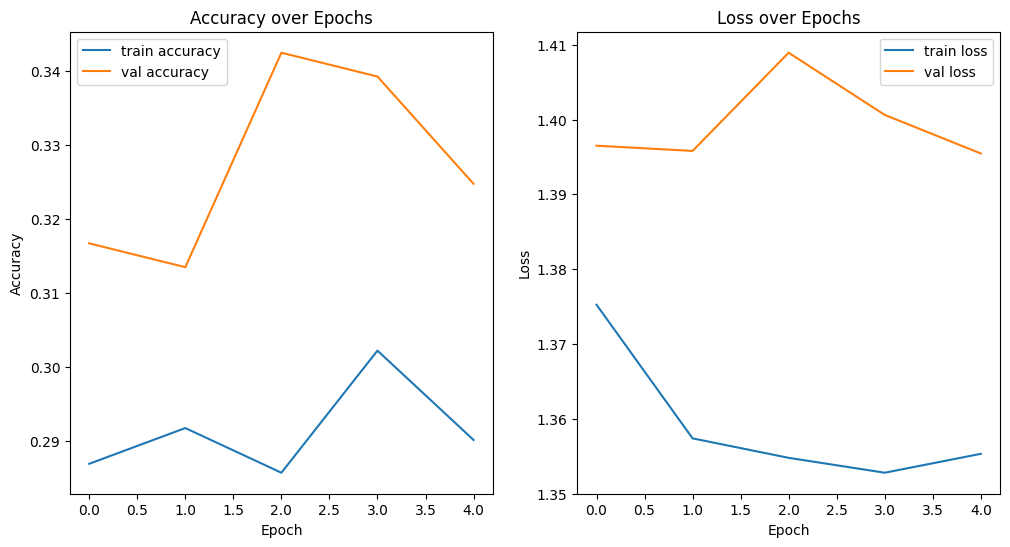

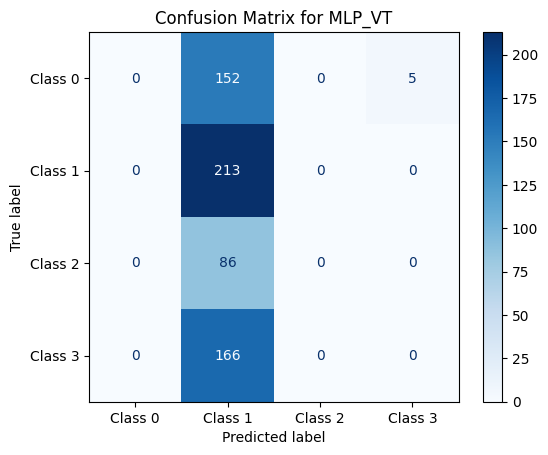

In [4]:
# Loop through each data split (typically 'train' and 'val' for training and validation)
for split in ['train', 'val']:
    # Print accuracy and loss metrics for each epoch within the training and validation phases
    print(split, 'accuracies by epoch:', accuracies[split])
    print(split, 'losses by epoch:', losses[split])

# Save the state dictionary of the model to a file for later use or deployment
torch.save(model_ft.state_dict(), '../../models/MLP_VT_best_model.pt')

# Assume plot_training_history and plot_confusion_matrix are defined elsewhere in the codebase.
# These functions generate visualizations for the model's training history and performance.

# Plot the training history using the updated accuracies and losses dictionaries.
# This function will generate a plot showing the accuracy and loss over all training epochs.
plot_training_history(accuracies, losses, 'MLP_VT')

# Plot the confusion matrix for the model's predictions compared to the true labels.
# This visualization helps in understanding the model's performance across different classes.
plot_confusion_matrix(labels, preds, 'MLP_VT')
